In [161]:
!pip install pandas numpy torchvision 

In [162]:
%reload_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# import pandas as pd
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
# import numpy as np
# import os 
import torch.optim.lr_scheduler as lr_scheduler
# from PIL import Image
# from torchvision import transforms
# import cv2
# from generate_datasetHM import HeatmapDataset
from asteroids.generate_datasetSQ import CustomDataset
# from generate_datasetSQ import CustomDataset
import matplotlib.pyplot as plt
from CNNs.models import CNN2,CNN1
from CNNs.modelsLSTM import Conv_LSTM, CNNLSTM,RNN1

from analysis import plot_circles_on_image,pixel_distance,Metrics,epoch_metrics,error_calc
import copy
from tqdm import tqdm

# Train models to find the center of Brightness of a celectial object usint LTSM
## Objects:
- Mars
- Asteroids
## Models:
- LTSM 

In [163]:
# Load the datasets
train_dataset = torch.load('train_datasetSQ.pth')
val_dataset= torch.load('val_datasetSQ.pth')
test_dataset = torch.load('test_datasetSQ.pth')

In [164]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader =   DataLoader(val_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=22, shuffle=True)

In [165]:
for images, labels in train_loader:
    print(images.shape)  # Should be (batch_size, sequence_length, 1, 256, 256)
    print(labels.shape)  # Should be (batch_size, sequence_length, 2)
    break

torch.Size([20, 3, 1, 256, 256])
torch.Size([20, 3, 2])


In [166]:
len(train_dataset)
len(val_dataset)
print(len(train_dataset)+len(val_dataset)+len(test_dataset))

101247


In [175]:
def plot_results(num_epochs, train_losses, val_losses, val_distances):
   epochs = range(1, num_epochs + 1)
   plt.rcParams.update({'font.size': 24})
   dark_grey= '#3b3b3b'
   # Plotting all the losses
   plt.figure(figsize=(12, 6))
#    for i in range(len(train_losses)):
#        if train_losses[i] >=500:
#            train_losses[i]=train_losses[i+1]
#        if val_losses[i] >=200:
#            val_losses[i]=val_losses[i+1]
#        if val_distances[i]>= 10:
#            val_distances[i]=val_distances[i+1]
   plt.scatter(epochs, train_losses, label='Training Loss')
   plt.scatter(epochs, val_losses, label='Validation Loss')
   plt.xlabel('Epochs', color=dark_grey)
   plt.ylabel('Loss', color=dark_grey)
   plt.legend(labelcolor=dark_grey)
   plt.title('Training and Validation Loss', color=dark_grey)
   plt.tight_layout()
#    plt.savefig("pics//asteroids//Valtrain_loss_ast_COB3.pdf", format="pdf")
   plt.show()

   # Plotting all the distances
   plt.figure(figsize=(12, 6))

   plt.scatter(epochs, val_distances, label='Validation Distance', color='green')
   plt.xlabel('Epochs', color=dark_grey)
   plt.ylabel('Distance', color=dark_grey)
   plt.legend( labelcolor=dark_grey)
   plt.title('Pixel Distance', color=dark_grey)
   plt.tight_layout()
#    plt.savefig("pics//asteroids//Valdistance_ast_COB3.pdf", format="pdf")
   plt.show()


def plot_metrics(num_epochs, metrics, threshold=15):
    epochs = range(1, num_epochs + 1)

    # Adjust values if MSE exceeds the threshold
    if 'MSE' in metrics:
        mse_values = metrics['MSE']
        for i in range(len(mse_values) - 1):
            if mse_values[i] > threshold:
                for metric, values in metrics.items():
                    values[i] = values[i + 1]
        if mse_values[-1] > threshold:
            for metric, values in metrics.items():
                values[-1] = None  # Last value handling, set to None if it exceeds the threshold
    
    # Create a figure with a 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 6))
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

    for i, (metric, values) in enumerate(metrics.items()):
        if None in values:  # Handling None values
            valid_epochs = [epoch for epoch, value in zip(epochs, values) if value is not None]
            valid_values = [value for value in values if value is not None]
            axes[i].plot(valid_epochs, valid_values, label=metric)
        else:
            axes[i].plot(epochs, values, label=metric)
        
        axes[i].set_xlabel('Epochs')
        axes[i].set_ylabel('Value')
        axes[i].set_title(f'{metric} over Epochs')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

In [168]:
def calculate_accuracy(outputs, targets):
    total_distance = 0
    for output, target in zip(outputs, targets):
        distance = ((target[0] - output[0]) ** 2 + (target[1] - output[1]) ** 2) ** 0.5
        total_distance += distance
    return total_distance / len(outputs)

In [169]:
def train(valloader, dataloader, model, device='cpu'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)

    patience = 7
    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    no_improvement_counter = 0

    train_losses = []
    val_losses = []
    val_distances = []
    accuracies = []
    metrics_history = {'MAE': [], 'MSE': [], 'RMSE': [], 'R-squared': []}

    num_epochs = 80
    for epoch in range(num_epochs):
        print("##### epoch {} : #####".format(epoch + 1))

        model.train()
        running_loss = 0.0
        tot = 0.0
        b = 0.0

        for inputs, targets in tqdm(dataloader):
            tot += dataloader.batch_size
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            # Ensure outputs have the correct shape (batch_size, num_classes)
            t=targets[:, -1, :]
            o=outputs[:, -1, :]

            loss = criterion(outputs, targets)  # Use the last label in the sequence
            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)

            optimizer.step()
            running_loss += loss.item()
            b += 1.0
            if b % 1000 == 0:
                print("batch: {}: Running Loss  {:.4f}".format(b, running_loss / b))
                # print(f'Outputs : {o[:3]}')  # Should be (batch_size, output_size)
                # print(f'Labels : {t[:3]}')  # Should be (batch_size,)

        train_loss = running_loss / len(dataloader)
        train_losses.append(train_loss)

        model.eval()

        validation_loss = 0.0
        total_distance = 0.0
        counter = 0.0
        Error = 0.0
        metrics = {'MAE': 0.0, 'MSE': 0.0, 'RMSE': 0.0, 'R-squared': 0.0, 'count': 0}

        with torch.no_grad():
            for x, y in valloader:
                x_val, y_val = x.to(device), y.to(device)
                val_result = model(x_val)
                lossv = criterion(val_result, y_val)  # Use the last label in the sequence
                validation_loss += lossv.item()
                d, c = pixel_distance(val_result[:, -1, :], y_val[:, -1, :])
                Error += error_calc(val_result[:, -1, :], y_val[:, -1, :])
                total_distance += d.item()
                counter += c
                Metrics(metrics, val_result[:, -1, :], y_val[:, -1, :])

        avg_val_loss = validation_loss / len(valloader)
        avg_val_distance = total_distance / len(valloader)
        accuracy = 100 * (counter / len(valloader.dataset))
        Error /= len(valloader)
        val_losses.append(avg_val_loss)
        val_distances.append(avg_val_distance)
        accuracies.append(accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}\n"
              f"Validation Distance: {avg_val_distance:.4f}, Validation Accuracy: {accuracy:.4f}, Error: {Error:.4f}")
        epoch_metric = epoch_metrics(metrics)
        for metric, value in epoch_metric.items():
            metrics_history[metric].append(value)
        scheduler.step(avg_val_loss)
        scheduler.get_last_lr()
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1
            if no_improvement_counter >= patience:
                print("Early stopping triggered")
                num_epochs = epoch + 1
                break

    model.load_state_dict(best_model_wts)
    plot_results(num_epochs, train_losses, val_losses, val_distances)
    return model, train_losses, val_losses, val_distances, metrics_history


In [170]:
def Test(model, testloader, device='cpu'):
    model.to(device)
    model.eval()
    num_epochs = 5
    # criterion = nn.SmoothL1Loss()
    criterion = nn.MSELoss()
    test_losses = []
    test_distances = []
    accuracies = []
    Error = 0.0

    for epoch in range(num_epochs):
        print("##### epoch {} : #####".format(epoch + 1))
        metrics = {'MAE': 0.0, 'MSE': 0.0, 'RMSE': 0.0, 'R-squared': 0.0, 'count': 0}

        test_loss = 0.0
        total_distance = 0.0
        counter = 0.0
        n = 0.0
        with torch.no_grad():
            for x, y in testloader:
                x_test, y_test = x.to(device), y.to(device)
                test_result = model(x_test)
                losst = criterion(test_result, y_test)
                test_loss += losst.item()
                d, c = pixel_distance(test_result[:, -1, :], y_test[:, -1, :])
                total_distance += d
                counter += c
                Metrics(metrics, test_result[:, -1, :], y_test[:, -1, :])
                if n % 50 == 0:
                    plot_circles_on_image(x_test[0, -1, :], test_result[0, -1, :], y_test[0, -1, :])
                n += 1.0

                Error += error_calc(test_result[:, -1, :], y_test[:, -1, :])
                counter += c

        Error /= len(testloader)
        avg_test_loss = test_loss / len(testloader)
        avg_test_distance = total_distance / len(testloader)
        accuracy = 100 * (counter / len(testloader.dataset))
        test_losses.append(avg_test_loss)
        test_distances.append(avg_test_distance)
        accuracies.append(accuracy)
        print(f"Test Loss: {avg_test_loss:.4f}, Test Distance: {avg_test_distance:.4f}, Error: {Error:.4f}")
        epoch_metric = epoch_metrics(metrics)

    return test_losses, test_distances, accuracies

** GPU **
##### epoch 1 : #####


 28%|██▊       | 1000/3546 [07:26<18:51,  2.25it/s]

batch: 1000.0: Running Loss  2672.8453


 56%|█████▋    | 2000/3546 [14:52<11:25,  2.26it/s]

batch: 2000.0: Running Loss  1389.1896


 85%|████████▍ | 3000/3546 [22:14<04:02,  2.25it/s]

batch: 3000.0: Running Loss  933.5921


100%|██████████| 3546/3546 [26:16<00:00,  2.25it/s]


Epoch 1/80, Training Loss: 793.2995, Validation Loss: 3.8519
Validation Distance: 2.4334, Validation Accuracy: 99.3224, Error: 1.3399
##Metrics##:
MAE : 1.6330606937408447
MSE : 4.003604888916016
RMSE : 1.4045367240905762
R-squared : 0.9928838610649109
Count: 40144
##### epoch 2 : #####


 28%|██▊       | 1000/3546 [07:20<18:41,  2.27it/s]

batch: 1000.0: Running Loss  7.9030


 56%|█████▋    | 2000/3546 [14:41<11:22,  2.27it/s]

batch: 2000.0: Running Loss  6.5351


 85%|████████▍ | 3000/3546 [22:02<04:00,  2.27it/s]

batch: 3000.0: Running Loss  6.4897


100%|██████████| 3546/3546 [26:03<00:00,  2.27it/s]


Epoch 2/80, Training Loss: 5.9023, Validation Loss: 0.7290
Validation Distance: 1.0656, Validation Accuracy: 99.6662, Error: 0.5866
##Metrics##:
MAE : 0.6809078454971313
MSE : 0.9191700220108032
RMSE : 0.951992392539978
R-squared : 0.9984777569770813
Count: 40144
##### epoch 3 : #####


 28%|██▊       | 1000/3546 [07:22<18:45,  2.26it/s]

batch: 1000.0: Running Loss  4.5106


 56%|█████▋    | 2000/3546 [14:44<11:21,  2.27it/s]

batch: 2000.0: Running Loss  3.6634


 85%|████████▍ | 3000/3546 [22:06<04:00,  2.27it/s]

batch: 3000.0: Running Loss  3.2551


100%|██████████| 3546/3546 [26:07<00:00,  2.26it/s]


Epoch 3/80, Training Loss: 3.1400, Validation Loss: 0.9785
Validation Distance: 0.7500, Validation Accuracy: 99.8306, Error: 0.4133
##Metrics##:
MAE : 0.47833484411239624
MSE : 0.7780064344406128
RMSE : 0.8398110270500183
R-squared : 0.9987789392471313
Count: 40144
##### epoch 4 : #####


 28%|██▊       | 1000/3546 [07:20<18:47,  2.26it/s]

batch: 1000.0: Running Loss  4.2630


 56%|█████▋    | 2000/3546 [14:42<11:20,  2.27it/s]

batch: 2000.0: Running Loss  3.8174


 85%|████████▍ | 3000/3546 [22:02<04:01,  2.26it/s]

batch: 3000.0: Running Loss  3.6771


100%|██████████| 3546/3546 [26:04<00:00,  2.27it/s]


Epoch 4/80, Training Loss: 3.3983, Validation Loss: 0.5494
Validation Distance: 0.9575, Validation Accuracy: 99.9253, Error: 0.5274
##Metrics##:
MAE : 0.6049017310142517
MSE : 0.6215754151344299
RMSE : 0.8796616196632385
R-squared : 0.9989026784896851
Count: 40144
##### epoch 5 : #####


 28%|██▊       | 1000/3546 [07:21<18:33,  2.29it/s]

batch: 1000.0: Running Loss  2.0977


 56%|█████▋    | 2000/3546 [14:40<11:13,  2.29it/s]

batch: 2000.0: Running Loss  2.0536


 85%|████████▍ | 3000/3546 [22:02<04:01,  2.26it/s]

batch: 3000.0: Running Loss  2.0461


100%|██████████| 3546/3546 [26:04<00:00,  2.27it/s]


Epoch 5/80, Training Loss: 2.0002, Validation Loss: 0.3959
Validation Distance: 0.7725, Validation Accuracy: 99.8904, Error: 0.4254
##Metrics##:
MAE : 0.4902886748313904
MSE : 0.48992469906806946
RMSE : 0.8188069462776184
R-squared : 0.9991725087165833
Count: 40144
##### epoch 6 : #####


 28%|██▊       | 1000/3546 [07:22<18:45,  2.26it/s]

batch: 1000.0: Running Loss  3.0904


 56%|█████▋    | 2000/3546 [14:44<11:20,  2.27it/s]

batch: 2000.0: Running Loss  2.2390


 85%|████████▍ | 3000/3546 [22:03<03:58,  2.29it/s]

batch: 3000.0: Running Loss  1.9845


100%|██████████| 3546/3546 [26:02<00:00,  2.27it/s]


Epoch 6/80, Training Loss: 2.0963, Validation Loss: 7.0832
Validation Distance: 1.7080, Validation Accuracy: 97.9026, Error: 0.9419
##Metrics##:
MAE : 1.0675076246261597
MSE : 7.178362846374512
RMSE : 1.3740750551223755
R-squared : 0.988175094127655
Count: 40144
##### epoch 7 : #####


 28%|██▊       | 1000/3546 [07:18<18:34,  2.28it/s]

batch: 1000.0: Running Loss  1.9009


 56%|█████▋    | 2000/3546 [14:37<11:17,  2.28it/s]

batch: 2000.0: Running Loss  1.5878


 85%|████████▍ | 3000/3546 [21:55<03:58,  2.29it/s]

batch: 3000.0: Running Loss  1.4592


100%|██████████| 3546/3546 [25:54<00:00,  2.28it/s]


Epoch 7/80, Training Loss: 1.3739, Validation Loss: 0.3089
Validation Distance: 0.6557, Validation Accuracy: 99.9253, Error: 0.3617
##Metrics##:
MAE : 0.42190608382225037
MSE : 0.36457303166389465
RMSE : 0.7579824924468994
R-squared : 0.9993877410888672
Count: 40144
##### epoch 8 : #####


 28%|██▊       | 1000/3546 [07:17<18:34,  2.28it/s]

batch: 1000.0: Running Loss  0.8219


 56%|█████▋    | 2000/3546 [14:34<11:14,  2.29it/s]

batch: 2000.0: Running Loss  1.7301


 85%|████████▍ | 3000/3546 [21:52<03:58,  2.29it/s]

batch: 3000.0: Running Loss  1.8826


100%|██████████| 3546/3546 [25:50<00:00,  2.29it/s]


Epoch 8/80, Training Loss: 1.7062, Validation Loss: 0.2638
Validation Distance: 0.4981, Validation Accuracy: 99.8954, Error: 0.2745
##Metrics##:
MAE : 0.3155874013900757
MSE : 0.3197902739048004
RMSE : 0.682658314704895
R-squared : 0.9994972348213196
Count: 40144
##### epoch 9 : #####


 28%|██▊       | 1000/3546 [07:17<18:34,  2.28it/s]

batch: 1000.0: Running Loss  0.7068


 56%|█████▋    | 2000/3546 [14:36<11:18,  2.28it/s]

batch: 2000.0: Running Loss  0.7975


 85%|████████▍ | 3000/3546 [21:54<03:58,  2.29it/s]

batch: 3000.0: Running Loss  0.8295


100%|██████████| 3546/3546 [25:52<00:00,  2.28it/s]


Epoch 9/80, Training Loss: 0.9173, Validation Loss: 0.4051
Validation Distance: 0.8353, Validation Accuracy: 99.9801, Error: 0.4603
##Metrics##:
MAE : 0.5358883142471313
MSE : 0.4726160168647766
RMSE : 0.8215572237968445
R-squared : 0.9991660118103027
Count: 40144
##### epoch 10 : #####


 28%|██▊       | 1000/3546 [07:17<18:38,  2.28it/s]

batch: 1000.0: Running Loss  0.8802


 56%|█████▋    | 2000/3546 [14:34<11:13,  2.30it/s]

batch: 2000.0: Running Loss  0.9270


 85%|████████▍ | 3000/3546 [21:52<03:58,  2.29it/s]

batch: 3000.0: Running Loss  0.9893


100%|██████████| 3546/3546 [25:52<00:00,  2.28it/s]


Epoch 10/80, Training Loss: 1.1706, Validation Loss: 0.2245
Validation Distance: 0.6939, Validation Accuracy: 99.9851, Error: 0.3823
##Metrics##:
MAE : 0.44241365790367126
MSE : 0.30351847410202026
RMSE : 0.7361410856246948
R-squared : 0.9994572401046753
Count: 40144
##### epoch 11 : #####


 28%|██▊       | 1000/3546 [07:18<18:37,  2.28it/s]

batch: 1000.0: Running Loss  0.8057


 56%|█████▋    | 2000/3546 [14:36<11:16,  2.29it/s]

batch: 2000.0: Running Loss  1.2258


 85%|████████▍ | 3000/3546 [21:54<04:00,  2.27it/s]

batch: 3000.0: Running Loss  1.0164


100%|██████████| 3546/3546 [25:53<00:00,  2.28it/s]


Epoch 11/80, Training Loss: 0.9549, Validation Loss: 0.1867
Validation Distance: 0.4784, Validation Accuracy: 99.9950, Error: 0.2636
##Metrics##:
MAE : 0.3033740818500519
MSE : 0.1916138380765915
RMSE : 0.6465377807617188
R-squared : 0.9996821880340576
Count: 40144
##### epoch 12 : #####


 28%|██▊       | 1000/3546 [07:17<18:30,  2.29it/s]

batch: 1000.0: Running Loss  0.8981


 56%|█████▋    | 2000/3546 [14:35<11:16,  2.29it/s]

batch: 2000.0: Running Loss  0.7247


 85%|████████▍ | 3000/3546 [21:52<03:59,  2.28it/s]

batch: 3000.0: Running Loss  0.7331


100%|██████████| 3546/3546 [25:51<00:00,  2.29it/s]


Epoch 12/80, Training Loss: 0.8061, Validation Loss: 0.2964
Validation Distance: 0.5948, Validation Accuracy: 99.9552, Error: 0.3280
##Metrics##:
MAE : 0.3567589223384857
MSE : 0.3450634777545929
RMSE : 0.7226089239120483
R-squared : 0.999398946762085
Count: 40144
##### epoch 13 : #####


 28%|██▊       | 1000/3546 [07:18<18:38,  2.28it/s]

batch: 1000.0: Running Loss  0.5985


 56%|█████▋    | 2000/3546 [14:36<11:18,  2.28it/s]

batch: 2000.0: Running Loss  0.5987


 85%|████████▍ | 3000/3546 [21:54<03:57,  2.30it/s]

batch: 3000.0: Running Loss  0.8341


100%|██████████| 3546/3546 [25:53<00:00,  2.28it/s]


Epoch 13/80, Training Loss: 1.2465, Validation Loss: 258.1060
Validation Distance: 17.6064, Validation Accuracy: 15.4145, Error: 9.6968
##Metrics##:
MAE : 11.194777488708496
MSE : 258.4014587402344
RMSE : 3.9315311908721924
R-squared : 0.5770294070243835
Count: 40144
##### epoch 14 : #####


 28%|██▊       | 1000/3546 [07:18<18:32,  2.29it/s]

batch: 1000.0: Running Loss  0.4700


 56%|█████▋    | 2000/3546 [14:36<11:20,  2.27it/s]

batch: 2000.0: Running Loss  0.7234


 85%|████████▍ | 3000/3546 [21:54<03:59,  2.28it/s]

batch: 3000.0: Running Loss  0.8864


100%|██████████| 3546/3546 [25:53<00:00,  2.28it/s]


Epoch 14/80, Training Loss: 0.8257, Validation Loss: 3.5031
Validation Distance: 0.5032, Validation Accuracy: 99.8306, Error: 0.2775
##Metrics##:
MAE : 0.3111898899078369
MSE : 3.528458595275879
RMSE : 0.8014984130859375
R-squared : 0.9937885999679565
Count: 40144
##### epoch 15 : #####


 28%|██▊       | 1000/3546 [07:17<18:37,  2.28it/s]

batch: 1000.0: Running Loss  0.7727


 56%|█████▋    | 2000/3546 [14:35<11:17,  2.28it/s]

batch: 2000.0: Running Loss  0.7871


 85%|████████▍ | 3000/3546 [21:53<03:58,  2.29it/s]

batch: 3000.0: Running Loss  0.8164


100%|██████████| 3546/3546 [25:52<00:00,  2.28it/s]


Epoch 15/80, Training Loss: 0.9201, Validation Loss: 0.1920
Validation Distance: 0.5132, Validation Accuracy: 99.9751, Error: 0.2830
##Metrics##:
MAE : 0.3285982608795166
MSE : 0.2198343575000763
RMSE : 0.6647561192512512
R-squared : 0.9996183514595032
Count: 40144
##### epoch 16 : #####


 28%|██▊       | 1000/3546 [07:17<18:32,  2.29it/s]

batch: 1000.0: Running Loss  0.1892


 56%|█████▋    | 2000/3546 [14:35<11:13,  2.29it/s]

batch: 2000.0: Running Loss  0.2173


 85%|████████▍ | 3000/3546 [21:52<03:58,  2.29it/s]

batch: 3000.0: Running Loss  0.2156


100%|██████████| 3546/3546 [25:51<00:00,  2.29it/s]


Epoch 16/80, Training Loss: 0.1983, Validation Loss: 0.0375
Validation Distance: 0.2070, Validation Accuracy: 100.0000, Error: 0.1140
##Metrics##:
MAE : 0.13142554461956024
MSE : 0.04258302226662636
RMSE : 0.43539318442344666
R-squared : 0.9999306201934814
Count: 40144
##### epoch 17 : #####


 28%|██▊       | 1000/3546 [07:17<18:35,  2.28it/s]

batch: 1000.0: Running Loss  0.1348


 56%|█████▋    | 2000/3546 [14:35<11:17,  2.28it/s]

batch: 2000.0: Running Loss  0.1870


 85%|████████▍ | 3000/3546 [21:54<04:00,  2.27it/s]

batch: 3000.0: Running Loss  0.1610


100%|██████████| 3546/3546 [25:55<00:00,  2.28it/s]


Epoch 17/80, Training Loss: 0.1512, Validation Loss: 0.0304
Validation Distance: 0.1824, Validation Accuracy: 100.0000, Error: 0.1004
##Metrics##:
MAE : 0.11558671295642853
MSE : 0.033437639474868774
RMSE : 0.4096135199069977
R-squared : 0.9999458193778992
Count: 40144
##### epoch 18 : #####


 28%|██▊       | 1000/3546 [07:20<18:32,  2.29it/s]

batch: 1000.0: Running Loss  0.1293


 56%|█████▋    | 2000/3546 [14:40<11:17,  2.28it/s]

batch: 2000.0: Running Loss  0.1994


 85%|████████▍ | 3000/3546 [21:58<04:01,  2.27it/s]

batch: 3000.0: Running Loss  0.1639


100%|██████████| 3546/3546 [25:57<00:00,  2.28it/s]


Epoch 18/80, Training Loss: 0.1547, Validation Loss: 0.0314
Validation Distance: 0.1798, Validation Accuracy: 100.0000, Error: 0.0989
##Metrics##:
MAE : 0.112769216299057
MSE : 0.03658391162753105
RMSE : 0.41569453477859497
R-squared : 0.9999418258666992
Count: 40144
##### epoch 19 : #####


 28%|██▊       | 1000/3546 [07:18<18:37,  2.28it/s]

batch: 1000.0: Running Loss  0.1099


 56%|█████▋    | 2000/3546 [14:36<11:16,  2.28it/s]

batch: 2000.0: Running Loss  0.1942


 85%|████████▍ | 3000/3546 [21:53<03:58,  2.29it/s]

batch: 3000.0: Running Loss  0.1603


100%|██████████| 3546/3546 [25:52<00:00,  2.28it/s]


Epoch 19/80, Training Loss: 0.1577, Validation Loss: 0.0235
Validation Distance: 0.1684, Validation Accuracy: 100.0000, Error: 0.0928
##Metrics##:
MAE : 0.10829164832830429
MSE : 0.025184916332364082
RMSE : 0.3863116502761841
R-squared : 0.9999589323997498
Count: 40144
##### epoch 20 : #####


 28%|██▊       | 1000/3546 [07:17<18:33,  2.29it/s]

batch: 1000.0: Running Loss  0.0889


 56%|█████▋    | 2000/3546 [14:34<11:12,  2.30it/s]

batch: 2000.0: Running Loss  0.0929


 85%|████████▍ | 3000/3546 [21:51<03:58,  2.29it/s]

batch: 3000.0: Running Loss  0.1333


100%|██████████| 3546/3546 [25:50<00:00,  2.29it/s]


Epoch 20/80, Training Loss: 0.1408, Validation Loss: 0.0296
Validation Distance: 0.1698, Validation Accuracy: 100.0000, Error: 0.0935
##Metrics##:
MAE : 0.10535081475973129
MSE : 0.03234819322824478
RMSE : 0.4032715857028961
R-squared : 0.999949038028717
Count: 40144
##### epoch 21 : #####


 28%|██▊       | 1000/3546 [07:16<18:31,  2.29it/s]

batch: 1000.0: Running Loss  0.0796


 56%|█████▋    | 2000/3546 [14:34<11:17,  2.28it/s]

batch: 2000.0: Running Loss  0.0830


 85%|████████▍ | 3000/3546 [21:55<04:00,  2.27it/s]

batch: 3000.0: Running Loss  0.0906


100%|██████████| 3546/3546 [25:56<00:00,  2.28it/s]


Epoch 21/80, Training Loss: 0.1355, Validation Loss: 0.0240
Validation Distance: 0.1675, Validation Accuracy: 100.0000, Error: 0.0922
##Metrics##:
MAE : 0.10656428337097168
MSE : 0.02637268602848053
RMSE : 0.38919466733932495
R-squared : 0.9999575614929199
Count: 40144
##### epoch 22 : #####


 28%|██▊       | 1000/3546 [07:20<18:41,  2.27it/s]

batch: 1000.0: Running Loss  0.0820


 56%|█████▋    | 2000/3546 [14:41<11:21,  2.27it/s]

batch: 2000.0: Running Loss  0.1537


 85%|████████▍ | 3000/3546 [22:02<04:00,  2.27it/s]

batch: 3000.0: Running Loss  0.1503


100%|██████████| 3546/3546 [26:03<00:00,  2.27it/s]


Epoch 22/80, Training Loss: 0.1411, Validation Loss: 0.0171
Validation Distance: 0.1348, Validation Accuracy: 100.0000, Error: 0.0742
##Metrics##:
MAE : 0.0850670114159584
MSE : 0.01890946738421917
RMSE : 0.35472628474235535
R-squared : 0.9999726414680481
Count: 40144
##### epoch 23 : #####


 28%|██▊       | 1000/3546 [07:20<18:48,  2.26it/s]

batch: 1000.0: Running Loss  0.0844


 56%|█████▋    | 2000/3546 [14:42<11:20,  2.27it/s]

batch: 2000.0: Running Loss  0.0981


 85%|████████▍ | 3000/3546 [22:03<04:00,  2.27it/s]

batch: 3000.0: Running Loss  0.1223


100%|██████████| 3546/3546 [26:04<00:00,  2.27it/s]


Epoch 23/80, Training Loss: 0.1200, Validation Loss: 0.0239
Validation Distance: 0.1571, Validation Accuracy: 100.0000, Error: 0.0865
##Metrics##:
MAE : 0.1005142331123352
MSE : 0.02460082434117794
RMSE : 0.38062894344329834
R-squared : 0.9999618530273438
Count: 40144
##### epoch 24 : #####


 28%|██▊       | 1000/3546 [07:20<18:39,  2.28it/s]

batch: 1000.0: Running Loss  0.1703


 56%|█████▋    | 2000/3546 [14:41<11:21,  2.27it/s]

batch: 2000.0: Running Loss  0.1308


 85%|████████▍ | 3000/3546 [22:02<04:00,  2.27it/s]

batch: 3000.0: Running Loss  0.1223


100%|██████████| 3546/3546 [26:03<00:00,  2.27it/s]


Epoch 24/80, Training Loss: 0.1209, Validation Loss: 0.0311
Validation Distance: 0.2275, Validation Accuracy: 100.0000, Error: 0.1253
##Metrics##:
MAE : 0.1484670639038086
MSE : 0.038166485726833344
RMSE : 0.43352270126342773
R-squared : 0.9999332427978516
Count: 40144
##### epoch 25 : #####


 28%|██▊       | 1000/3546 [07:20<18:43,  2.27it/s]

batch: 1000.0: Running Loss  0.0622


 56%|█████▋    | 2000/3546 [14:42<11:20,  2.27it/s]

batch: 2000.0: Running Loss  0.1340


 85%|████████▍ | 3000/3546 [22:03<04:00,  2.27it/s]

batch: 3000.0: Running Loss  0.1204


100%|██████████| 3546/3546 [26:03<00:00,  2.27it/s]


Epoch 25/80, Training Loss: 0.1232, Validation Loss: 0.0205
Validation Distance: 0.1668, Validation Accuracy: 100.0000, Error: 0.0918
##Metrics##:
MAE : 0.10720495879650116
MSE : 0.02305564470589161
RMSE : 0.38070863485336304
R-squared : 0.9999615550041199
Count: 40144
##### epoch 26 : #####


 28%|██▊       | 1000/3546 [07:20<18:44,  2.27it/s]

batch: 1000.0: Running Loss  0.1978


 56%|█████▋    | 2000/3546 [14:42<11:19,  2.28it/s]

batch: 2000.0: Running Loss  0.1346


 85%|████████▍ | 3000/3546 [22:02<04:00,  2.27it/s]

batch: 3000.0: Running Loss  0.1109


100%|██████████| 3546/3546 [26:04<00:00,  2.27it/s]


Epoch 26/80, Training Loss: 0.1050, Validation Loss: 0.0234
Validation Distance: 0.1748, Validation Accuracy: 100.0000, Error: 0.0963
##Metrics##:
MAE : 0.1085272878408432
MSE : 0.026890994980931282
RMSE : 0.3907119035720825
R-squared : 0.9999563097953796
Count: 40144
##### epoch 27 : #####


 28%|██▊       | 1000/3546 [07:22<18:44,  2.26it/s]

batch: 1000.0: Running Loss  0.0516


 56%|█████▋    | 2000/3546 [14:44<11:23,  2.26it/s]

batch: 2000.0: Running Loss  0.0482


 85%|████████▍ | 3000/3546 [22:07<04:00,  2.27it/s]

batch: 3000.0: Running Loss  0.0796


100%|██████████| 3546/3546 [26:08<00:00,  2.26it/s]


Epoch 27/80, Training Loss: 0.0742, Validation Loss: 0.0137
Validation Distance: 0.1118, Validation Accuracy: 100.0000, Error: 0.0616
##Metrics##:
MAE : 0.07060186564922333
MSE : 0.014847925864160061
RMSE : 0.3286099135875702
R-squared : 0.9999821186065674
Count: 40144
##### epoch 28 : #####


 28%|██▊       | 1000/3546 [07:21<18:47,  2.26it/s]

batch: 1000.0: Running Loss  0.0544


 56%|█████▋    | 2000/3546 [14:42<11:20,  2.27it/s]

batch: 2000.0: Running Loss  0.0472


 85%|████████▍ | 3000/3546 [22:03<04:00,  2.27it/s]

batch: 3000.0: Running Loss  0.0645


100%|██████████| 3546/3546 [26:04<00:00,  2.27it/s]


Epoch 28/80, Training Loss: 0.0689, Validation Loss: 0.0125
Validation Distance: 0.1043, Validation Accuracy: 100.0000, Error: 0.0575
##Metrics##:
MAE : 0.06596875190734863
MSE : 0.013080409727990627
RMSE : 0.31725576519966125
R-squared : 0.9999852180480957
Count: 40144
##### epoch 29 : #####


 28%|██▊       | 1000/3546 [07:21<18:38,  2.28it/s]

batch: 1000.0: Running Loss  0.1625


 56%|█████▋    | 2000/3546 [14:42<11:21,  2.27it/s]

batch: 2000.0: Running Loss  0.1065


 85%|████████▍ | 3000/3546 [22:04<04:00,  2.27it/s]

batch: 3000.0: Running Loss  0.0902


100%|██████████| 3546/3546 [26:04<00:00,  2.27it/s]


Epoch 29/80, Training Loss: 0.0841, Validation Loss: 0.0139
Validation Distance: 0.1237, Validation Accuracy: 100.0000, Error: 0.0682
##Metrics##:
MAE : 0.07938320934772491
MSE : 0.014771520160138607
RMSE : 0.33473771810531616
R-squared : 0.9999803304672241
Count: 40144
##### epoch 30 : #####


 28%|██▊       | 1000/3546 [07:22<18:42,  2.27it/s]

batch: 1000.0: Running Loss  0.1290


 56%|█████▋    | 2000/3546 [14:44<11:22,  2.27it/s]

batch: 2000.0: Running Loss  0.0854


 85%|████████▍ | 3000/3546 [22:06<04:00,  2.27it/s]

batch: 3000.0: Running Loss  0.0861


100%|██████████| 3546/3546 [26:07<00:00,  2.26it/s]


Epoch 30/80, Training Loss: 0.0824, Validation Loss: 0.0124
Validation Distance: 0.0991, Validation Accuracy: 100.0000, Error: 0.0546
##Metrics##:
MAE : 0.06299767643213272
MSE : 0.013152188621461391
RMSE : 0.3178935945034027
R-squared : 0.9999850392341614
Count: 40144
##### epoch 31 : #####


 28%|██▊       | 1000/3546 [07:25<18:50,  2.25it/s]

batch: 1000.0: Running Loss  0.0810


 56%|█████▋    | 2000/3546 [14:49<11:26,  2.25it/s]

batch: 2000.0: Running Loss  0.1110


 85%|████████▍ | 3000/3546 [22:10<04:00,  2.27it/s]

batch: 3000.0: Running Loss  0.0870


100%|██████████| 3546/3546 [26:11<00:00,  2.26it/s]


Epoch 31/80, Training Loss: 0.0824, Validation Loss: 0.0116
Validation Distance: 0.0925, Validation Accuracy: 100.0000, Error: 0.0509
##Metrics##:
MAE : 0.05862241983413696
MSE : 0.012107322923839092
RMSE : 0.3090710937976837
R-squared : 0.9999861717224121
Count: 40144
##### epoch 32 : #####


 28%|██▊       | 1000/3546 [07:22<18:44,  2.26it/s]

batch: 1000.0: Running Loss  0.1100


 56%|█████▋    | 2000/3546 [14:44<11:18,  2.28it/s]

batch: 2000.0: Running Loss  0.0833


 85%|████████▍ | 3000/3546 [22:05<04:00,  2.27it/s]

batch: 3000.0: Running Loss  0.0711


100%|██████████| 3546/3546 [26:06<00:00,  2.26it/s]


Epoch 32/80, Training Loss: 0.0676, Validation Loss: 0.0124
Validation Distance: 0.0966, Validation Accuracy: 100.0000, Error: 0.0532
##Metrics##:
MAE : 0.0613006129860878
MSE : 0.013186968863010406
RMSE : 0.3164515495300293
R-squared : 0.9999844431877136
Count: 40144
##### epoch 33 : #####


 28%|██▊       | 1000/3546 [07:22<18:45,  2.26it/s]

batch: 1000.0: Running Loss  0.1231


 56%|█████▋    | 2000/3546 [14:44<11:20,  2.27it/s]

batch: 2000.0: Running Loss  0.0922


 85%|████████▍ | 3000/3546 [22:06<04:01,  2.26it/s]

batch: 3000.0: Running Loss  0.1028


100%|██████████| 3546/3546 [26:07<00:00,  2.26it/s]


Epoch 33/80, Training Loss: 0.0927, Validation Loss: 0.0111
Validation Distance: 0.1004, Validation Accuracy: 100.0000, Error: 0.0553
##Metrics##:
MAE : 0.06382914632558823
MSE : 0.012158416211605072
RMSE : 0.31351640820503235
R-squared : 0.9999856948852539
Count: 40144
##### epoch 34 : #####


 28%|██▊       | 1000/3546 [07:21<18:41,  2.27it/s]

batch: 1000.0: Running Loss  0.1194


 56%|█████▋    | 2000/3546 [14:41<11:22,  2.27it/s]

batch: 2000.0: Running Loss  0.0890


 85%|████████▍ | 3000/3546 [22:03<04:00,  2.27it/s]

batch: 3000.0: Running Loss  0.0754


100%|██████████| 3546/3546 [26:03<00:00,  2.27it/s]


Epoch 34/80, Training Loss: 0.0701, Validation Loss: 0.0157
Validation Distance: 0.1351, Validation Accuracy: 100.0000, Error: 0.0744
##Metrics##:
MAE : 0.0834103599190712
MSE : 0.01763162761926651
RMSE : 0.34774574637413025
R-squared : 0.9999755620956421
Count: 40144
##### epoch 35 : #####


 28%|██▊       | 1000/3546 [07:21<18:42,  2.27it/s]

batch: 1000.0: Running Loss  0.1390


 56%|█████▋    | 2000/3546 [14:43<11:19,  2.28it/s]

batch: 2000.0: Running Loss  0.0893


 85%|████████▍ | 3000/3546 [22:04<04:01,  2.27it/s]

batch: 3000.0: Running Loss  0.0874


100%|██████████| 3546/3546 [26:05<00:00,  2.27it/s]


Epoch 35/80, Training Loss: 0.0797, Validation Loss: 0.0128
Validation Distance: 0.1022, Validation Accuracy: 100.0000, Error: 0.0563
##Metrics##:
MAE : 0.06480672955513
MSE : 0.013681554235517979
RMSE : 0.31954437494277954
R-squared : 0.999983549118042
Count: 40144
##### epoch 36 : #####


 28%|██▊       | 1000/3546 [07:21<18:43,  2.27it/s]

batch: 1000.0: Running Loss  0.0504


 56%|█████▋    | 2000/3546 [14:44<11:22,  2.26it/s]

batch: 2000.0: Running Loss  0.0725


 85%|████████▍ | 3000/3546 [22:05<04:01,  2.26it/s]

batch: 3000.0: Running Loss  0.0715


100%|██████████| 3546/3546 [26:07<00:00,  2.26it/s]


Epoch 36/80, Training Loss: 0.0669, Validation Loss: 0.0113
Validation Distance: 0.0985, Validation Accuracy: 100.0000, Error: 0.0542
##Metrics##:
MAE : 0.062096789479255676
MSE : 0.012499067932367325
RMSE : 0.3145349621772766
R-squared : 0.9999850988388062
Count: 40144
##### epoch 37 : #####


 28%|██▊       | 1000/3546 [07:21<18:40,  2.27it/s]

batch: 1000.0: Running Loss  0.1220


 56%|█████▋    | 2000/3546 [14:43<11:21,  2.27it/s]

batch: 2000.0: Running Loss  0.0803


 85%|████████▍ | 3000/3546 [22:04<03:59,  2.28it/s]

batch: 3000.0: Running Loss  0.0709


100%|██████████| 3546/3546 [26:05<00:00,  2.26it/s]


Epoch 37/80, Training Loss: 0.0725, Validation Loss: 0.0121
Validation Distance: 0.0954, Validation Accuracy: 100.0000, Error: 0.0525
##Metrics##:
MAE : 0.06043887138366699
MSE : 0.012585223652422428
RMSE : 0.3121747076511383
R-squared : 0.99998539686203
Count: 40144
##### epoch 38 : #####


 28%|██▊       | 1000/3546 [07:21<20:12,  2.10it/s]

batch: 1000.0: Running Loss  0.0322


 56%|█████▋    | 2000/3546 [14:42<11:18,  2.28it/s]

batch: 2000.0: Running Loss  0.0360


 85%|████████▍ | 3000/3546 [22:03<04:00,  2.27it/s]

batch: 3000.0: Running Loss  0.0673


100%|██████████| 3546/3546 [26:04<00:00,  2.27it/s]


Epoch 38/80, Training Loss: 0.0665, Validation Loss: 0.0135
Validation Distance: 0.0958, Validation Accuracy: 100.0000, Error: 0.0528
##Metrics##:
MAE : 0.06072380766272545
MSE : 0.014223979786038399
RMSE : 0.3193686306476593
R-squared : 0.9999821186065674
Count: 40144
##### epoch 39 : #####


 28%|██▊       | 1000/3546 [07:22<18:41,  2.27it/s]

batch: 1000.0: Running Loss  0.0397


 56%|█████▋    | 2000/3546 [14:44<11:25,  2.25it/s]

batch: 2000.0: Running Loss  0.0701


 85%|████████▍ | 3000/3546 [22:06<04:00,  2.27it/s]

batch: 3000.0: Running Loss  0.0576


100%|██████████| 3546/3546 [26:08<00:00,  2.26it/s]


Epoch 39/80, Training Loss: 0.0749, Validation Loss: 0.0096
Validation Distance: 0.0805, Validation Accuracy: 100.0000, Error: 0.0444
##Metrics##:
MAE : 0.05114942044019699
MSE : 0.009967810474336147
RMSE : 0.2942447066307068
R-squared : 0.9999890923500061
Count: 40144
##### epoch 40 : #####


 28%|██▊       | 1000/3546 [07:22<18:39,  2.27it/s]

batch: 1000.0: Running Loss  0.0445


 56%|█████▋    | 2000/3546 [14:43<11:23,  2.26it/s]

batch: 2000.0: Running Loss  0.0540


 85%|████████▍ | 3000/3546 [22:05<03:59,  2.28it/s]

batch: 3000.0: Running Loss  0.0687


100%|██████████| 3546/3546 [26:06<00:00,  2.26it/s]


Epoch 40/80, Training Loss: 0.0628, Validation Loss: 0.0101
Validation Distance: 0.0824, Validation Accuracy: 100.0000, Error: 0.0453
##Metrics##:
MAE : 0.05212002992630005
MSE : 0.010603697039186954
RMSE : 0.29709866642951965
R-squared : 0.9999882578849792
Count: 40144
##### epoch 41 : #####


 28%|██▊       | 1000/3546 [07:22<18:51,  2.25it/s]

batch: 1000.0: Running Loss  0.0329


 56%|█████▋    | 2000/3546 [14:47<11:29,  2.24it/s]

batch: 2000.0: Running Loss  0.0355


 85%|████████▍ | 3000/3546 [22:12<04:01,  2.26it/s]

batch: 3000.0: Running Loss  0.0724


100%|██████████| 3546/3546 [26:14<00:00,  2.25it/s]


Epoch 41/80, Training Loss: 0.0689, Validation Loss: 0.0099
Validation Distance: 0.0817, Validation Accuracy: 100.0000, Error: 0.0450
##Metrics##:
MAE : 0.051833923906087875
MSE : 0.010220005176961422
RMSE : 0.29631778597831726
R-squared : 0.9999887943267822
Count: 40144
##### epoch 42 : #####


 28%|██▊       | 1000/3546 [07:21<18:47,  2.26it/s]

batch: 1000.0: Running Loss  0.0555


 56%|█████▋    | 2000/3546 [14:43<11:20,  2.27it/s]

batch: 2000.0: Running Loss  0.0787


 85%|████████▍ | 3000/3546 [22:05<04:00,  2.27it/s]

batch: 3000.0: Running Loss  0.0749


100%|██████████| 3546/3546 [26:06<00:00,  2.26it/s]


Epoch 42/80, Training Loss: 0.0680, Validation Loss: 0.0095
Validation Distance: 0.0797, Validation Accuracy: 100.0000, Error: 0.0439
##Metrics##:
MAE : 0.0505831241607666
MSE : 0.00990299042314291
RMSE : 0.29263195395469666
R-squared : 0.9999901056289673
Count: 40144
##### epoch 43 : #####


 28%|██▊       | 1000/3546 [07:21<18:42,  2.27it/s]

batch: 1000.0: Running Loss  0.0329


 56%|█████▋    | 2000/3546 [14:43<11:22,  2.27it/s]

batch: 2000.0: Running Loss  0.0360


 85%|████████▍ | 3000/3546 [22:03<04:00,  2.27it/s]

batch: 3000.0: Running Loss  0.0601


100%|██████████| 3546/3546 [26:04<00:00,  2.27it/s]


Epoch 43/80, Training Loss: 0.0731, Validation Loss: 0.0104
Validation Distance: 0.0854, Validation Accuracy: 100.0000, Error: 0.0471
##Metrics##:
MAE : 0.05405174195766449
MSE : 0.010899395681917667
RMSE : 0.2998867332935333
R-squared : 0.999987781047821
Count: 40144
##### epoch 44 : #####


 28%|██▊       | 1000/3546 [07:21<18:42,  2.27it/s]

batch: 1000.0: Running Loss  0.0320


 56%|█████▋    | 2000/3546 [14:44<11:22,  2.27it/s]

batch: 2000.0: Running Loss  0.0339


 85%|████████▍ | 3000/3546 [22:04<03:59,  2.28it/s]

batch: 3000.0: Running Loss  0.0733


100%|██████████| 3546/3546 [26:05<00:00,  2.26it/s]


Epoch 44/80, Training Loss: 0.0671, Validation Loss: 0.0108
Validation Distance: 0.0816, Validation Accuracy: 100.0000, Error: 0.0449
##Metrics##:
MAE : 0.05187128484249115
MSE : 0.011230375617742538
RMSE : 0.29879721999168396
R-squared : 0.999987781047821
Count: 40144
##### epoch 45 : #####


 28%|██▊       | 1000/3546 [07:17<18:31,  2.29it/s]

batch: 1000.0: Running Loss  0.0326


 56%|█████▋    | 2000/3546 [14:34<11:16,  2.28it/s]

batch: 2000.0: Running Loss  0.0343


 85%|████████▍ | 3000/3546 [21:52<03:57,  2.29it/s]

batch: 3000.0: Running Loss  0.0758


100%|██████████| 3546/3546 [25:50<00:00,  2.29it/s]


Epoch 45/80, Training Loss: 0.0922, Validation Loss: 0.0093
Validation Distance: 0.0780, Validation Accuracy: 100.0000, Error: 0.0429
##Metrics##:
MAE : 0.04947322607040405
MSE : 0.009636061266064644
RMSE : 0.290314257144928
R-squared : 0.9999895095825195
Count: 40144
##### epoch 46 : #####


 28%|██▊       | 1000/3546 [07:21<18:42,  2.27it/s]

batch: 1000.0: Running Loss  0.0456


 56%|█████▋    | 2000/3546 [14:44<11:21,  2.27it/s]

batch: 2000.0: Running Loss  0.0585


 85%|████████▍ | 3000/3546 [22:05<03:59,  2.28it/s]

batch: 3000.0: Running Loss  0.0695


100%|██████████| 3546/3546 [26:05<00:00,  2.26it/s]


Epoch 46/80, Training Loss: 0.0638, Validation Loss: 0.0098
Validation Distance: 0.0799, Validation Accuracy: 100.0000, Error: 0.0440
##Metrics##:
MAE : 0.050645917654037476
MSE : 0.010103598237037659
RMSE : 0.29373735189437866
R-squared : 0.9999892115592957
Count: 40144
##### epoch 47 : #####


 28%|██▊       | 1000/3546 [07:17<18:34,  2.28it/s]

batch: 1000.0: Running Loss  0.0877


 56%|█████▋    | 2000/3546 [14:35<11:14,  2.29it/s]

batch: 2000.0: Running Loss  0.0638


 85%|████████▍ | 3000/3546 [21:52<03:58,  2.28it/s]

batch: 3000.0: Running Loss  0.0600


100%|██████████| 3546/3546 [25:51<00:00,  2.28it/s]


Epoch 47/80, Training Loss: 0.0581, Validation Loss: 0.0097
Validation Distance: 0.0800, Validation Accuracy: 100.0000, Error: 0.0440
##Metrics##:
MAE : 0.05065181106328964
MSE : 0.010041560046374798
RMSE : 0.2926120162010193
R-squared : 0.9999892115592957
Count: 40144
##### epoch 48 : #####


 28%|██▊       | 1000/3546 [07:17<18:32,  2.29it/s]

batch: 1000.0: Running Loss  0.0669


 56%|█████▋    | 2000/3546 [14:35<11:15,  2.29it/s]

batch: 2000.0: Running Loss  0.0549


 85%|████████▍ | 3000/3546 [21:53<03:59,  2.28it/s]

batch: 3000.0: Running Loss  0.0504


100%|██████████| 3546/3546 [25:52<00:00,  2.28it/s]


Epoch 48/80, Training Loss: 0.0746, Validation Loss: 0.0096
Validation Distance: 0.0829, Validation Accuracy: 100.0000, Error: 0.0456
##Metrics##:
MAE : 0.05259277671575546
MSE : 0.01005246676504612
RMSE : 0.2951190173625946
R-squared : 0.9999890923500061
Count: 40144
##### epoch 49 : #####


 28%|██▊       | 1000/3546 [07:20<18:44,  2.26it/s]

batch: 1000.0: Running Loss  0.0473


 56%|█████▋    | 2000/3546 [14:42<11:22,  2.26it/s]

batch: 2000.0: Running Loss  0.0887


 85%|████████▍ | 3000/3546 [22:03<04:00,  2.27it/s]

batch: 3000.0: Running Loss  0.0702


100%|██████████| 3546/3546 [26:04<00:00,  2.27it/s]


Epoch 49/80, Training Loss: 0.0673, Validation Loss: 0.0093
Validation Distance: 0.0803, Validation Accuracy: 100.0000, Error: 0.0442
##Metrics##:
MAE : 0.05076822265982628
MSE : 0.00972773041576147
RMSE : 0.29284951090812683
R-squared : 0.9999901652336121
Count: 40144
##### epoch 50 : #####


 28%|██▊       | 1000/3546 [07:22<18:40,  2.27it/s]

batch: 1000.0: Running Loss  0.0409


 56%|█████▋    | 2000/3546 [14:44<11:22,  2.27it/s]

batch: 2000.0: Running Loss  0.0766


 85%|████████▍ | 3000/3546 [22:05<04:01,  2.26it/s]

batch: 3000.0: Running Loss  0.0694


100%|██████████| 3546/3546 [26:06<00:00,  2.26it/s]


Epoch 50/80, Training Loss: 0.0633, Validation Loss: 0.0094
Validation Distance: 0.0768, Validation Accuracy: 100.0000, Error: 0.0423
##Metrics##:
MAE : 0.04864943027496338
MSE : 0.0097662303596735
RMSE : 0.29036352038383484
R-squared : 0.9999889135360718
Count: 40144
##### epoch 51 : #####


 28%|██▊       | 1000/3546 [07:21<18:34,  2.28it/s]

batch: 1000.0: Running Loss  0.1103


 56%|█████▋    | 2000/3546 [14:39<11:17,  2.28it/s]

batch: 2000.0: Running Loss  0.0730


 85%|████████▍ | 3000/3546 [21:57<03:57,  2.29it/s]

batch: 3000.0: Running Loss  0.0673


100%|██████████| 3546/3546 [25:56<00:00,  2.28it/s]


Epoch 51/80, Training Loss: 0.0610, Validation Loss: 0.0091
Validation Distance: 0.0768, Validation Accuracy: 100.0000, Error: 0.0423
##Metrics##:
MAE : 0.0486878901720047
MSE : 0.009410440921783447
RMSE : 0.2887520492076874
R-squared : 0.9999901652336121
Count: 40144
##### epoch 52 : #####


 28%|██▊       | 1000/3546 [07:17<18:30,  2.29it/s]

batch: 1000.0: Running Loss  0.0580


 56%|█████▋    | 2000/3546 [14:34<11:15,  2.29it/s]

batch: 2000.0: Running Loss  0.0464


 85%|████████▍ | 3000/3546 [21:51<03:58,  2.29it/s]

batch: 3000.0: Running Loss  0.0478


100%|██████████| 3546/3546 [25:50<00:00,  2.29it/s]


Epoch 52/80, Training Loss: 0.0618, Validation Loss: 0.0113
Validation Distance: 0.0830, Validation Accuracy: 100.0000, Error: 0.0457
##Metrics##:
MAE : 0.052692972123622894
MSE : 0.011843780986964703
RMSE : 0.301520973443985
R-squared : 0.9999868869781494
Count: 40144
##### epoch 53 : #####


 28%|██▊       | 1000/3546 [07:16<18:34,  2.29it/s]

batch: 1000.0: Running Loss  0.0807


 56%|█████▋    | 2000/3546 [14:34<11:16,  2.29it/s]

batch: 2000.0: Running Loss  0.0673


 85%|████████▍ | 3000/3546 [21:51<03:59,  2.28it/s]

batch: 3000.0: Running Loss  0.0631


100%|██████████| 3546/3546 [25:50<00:00,  2.29it/s]


Epoch 53/80, Training Loss: 0.0597, Validation Loss: 0.0089
Validation Distance: 0.0759, Validation Accuracy: 100.0000, Error: 0.0418
##Metrics##:
MAE : 0.04803912341594696
MSE : 0.009266728535294533
RMSE : 0.2883402109146118
R-squared : 0.9999901652336121
Count: 40144
##### epoch 54 : #####


 28%|██▊       | 1000/3546 [07:17<18:43,  2.27it/s]

batch: 1000.0: Running Loss  0.0966


 56%|█████▋    | 2000/3546 [14:36<11:19,  2.27it/s]

batch: 2000.0: Running Loss  0.0966


 85%|████████▍ | 3000/3546 [21:53<03:59,  2.28it/s]

batch: 3000.0: Running Loss  0.0845


100%|██████████| 3546/3546 [25:52<00:00,  2.28it/s]


Epoch 54/80, Training Loss: 0.0761, Validation Loss: 0.0097
Validation Distance: 0.0782, Validation Accuracy: 100.0000, Error: 0.0431
##Metrics##:
MAE : 0.049618061631917953
MSE : 0.01016287598758936
RMSE : 0.2926054000854492
R-squared : 0.9999893307685852
Count: 40144
##### epoch 55 : #####


 28%|██▊       | 1000/3546 [07:17<18:31,  2.29it/s]

batch: 1000.0: Running Loss  0.0395


 56%|█████▋    | 2000/3546 [14:34<11:16,  2.29it/s]

batch: 2000.0: Running Loss  0.0648


 85%|████████▍ | 3000/3546 [21:52<03:58,  2.29it/s]

batch: 3000.0: Running Loss  0.0637


100%|██████████| 3546/3546 [25:51<00:00,  2.29it/s]


Epoch 55/80, Training Loss: 0.0617, Validation Loss: 0.0092
Validation Distance: 0.0763, Validation Accuracy: 100.0000, Error: 0.0421
##Metrics##:
MAE : 0.04833885282278061
MSE : 0.009552891366183758
RMSE : 0.2898543179035187
R-squared : 0.9999901056289673
Count: 40144
##### epoch 56 : #####


 28%|██▊       | 1000/3546 [07:17<18:45,  2.26it/s]

batch: 1000.0: Running Loss  0.0434


 56%|█████▋    | 2000/3546 [14:35<11:15,  2.29it/s]

batch: 2000.0: Running Loss  0.0910


 85%|████████▍ | 3000/3546 [21:53<03:58,  2.29it/s]

batch: 3000.0: Running Loss  0.0743


100%|██████████| 3546/3546 [25:52<00:00,  2.28it/s]


Epoch 56/80, Training Loss: 0.0681, Validation Loss: 0.0094
Validation Distance: 0.0770, Validation Accuracy: 100.0000, Error: 0.0424
##Metrics##:
MAE : 0.048745568841695786
MSE : 0.009712629951536655
RMSE : 0.2904966473579407
R-squared : 0.9999896287918091
Count: 40144
##### epoch 57 : #####


 28%|██▊       | 1000/3546 [07:18<18:34,  2.28it/s]

batch: 1000.0: Running Loss  0.1227


 56%|█████▋    | 2000/3546 [14:36<11:17,  2.28it/s]

batch: 2000.0: Running Loss  0.0914


 85%|████████▍ | 3000/3546 [21:54<03:58,  2.29it/s]

batch: 3000.0: Running Loss  0.1037


100%|██████████| 3546/3546 [25:53<00:00,  2.28it/s]


Epoch 57/80, Training Loss: 0.0933, Validation Loss: 0.0093
Validation Distance: 0.0760, Validation Accuracy: 100.0000, Error: 0.0419
##Metrics##:
MAE : 0.048142168670892715
MSE : 0.009652042761445045
RMSE : 0.2896955609321594
R-squared : 0.9999892115592957
Count: 40144
##### epoch 58 : #####


 28%|██▊       | 1000/3546 [07:16<18:30,  2.29it/s]

batch: 1000.0: Running Loss  0.0664


 56%|█████▋    | 2000/3546 [14:34<11:16,  2.29it/s]

batch: 2000.0: Running Loss  0.0490


 85%|████████▍ | 3000/3546 [21:51<03:58,  2.29it/s]

batch: 3000.0: Running Loss  0.0697


100%|██████████| 3546/3546 [25:50<00:00,  2.29it/s]


Epoch 58/80, Training Loss: 0.0661, Validation Loss: 0.0092
Validation Distance: 0.0757, Validation Accuracy: 100.0000, Error: 0.0417
##Metrics##:
MAE : 0.04792539030313492
MSE : 0.009528289549052715
RMSE : 0.2885722815990448
R-squared : 0.9999898076057434
Count: 40144
##### epoch 59 : #####


 28%|██▊       | 1000/3546 [07:17<18:29,  2.30it/s]

batch: 1000.0: Running Loss  0.0340


 56%|█████▋    | 2000/3546 [14:34<11:14,  2.29it/s]

batch: 2000.0: Running Loss  0.0451


 85%|████████▍ | 3000/3546 [21:53<03:59,  2.28it/s]

batch: 3000.0: Running Loss  0.0632


100%|██████████| 3546/3546 [25:51<00:00,  2.29it/s]


Epoch 59/80, Training Loss: 0.0597, Validation Loss: 0.0094
Validation Distance: 0.0758, Validation Accuracy: 100.0000, Error: 0.0418
##Metrics##:
MAE : 0.04805666208267212
MSE : 0.009754014201462269
RMSE : 0.28994858264923096
R-squared : 0.9999895095825195
Count: 40144
##### epoch 60 : #####


 28%|██▊       | 1000/3546 [07:21<18:40,  2.27it/s]

batch: 1000.0: Running Loss  0.1082


 56%|█████▋    | 2000/3546 [14:42<11:13,  2.29it/s]

batch: 2000.0: Running Loss  0.0708


 85%|████████▍ | 3000/3546 [22:01<04:00,  2.27it/s]

batch: 3000.0: Running Loss  0.0635


100%|██████████| 3546/3546 [26:02<00:00,  2.27it/s]


Epoch 60/80, Training Loss: 0.0627, Validation Loss: 0.0091
Validation Distance: 0.0755, Validation Accuracy: 100.0000, Error: 0.0416
##Metrics##:
MAE : 0.047789067029953
MSE : 0.009476330131292343
RMSE : 0.2883349061012268
R-squared : 0.9999893307685852
Count: 40144
Early stopping triggered


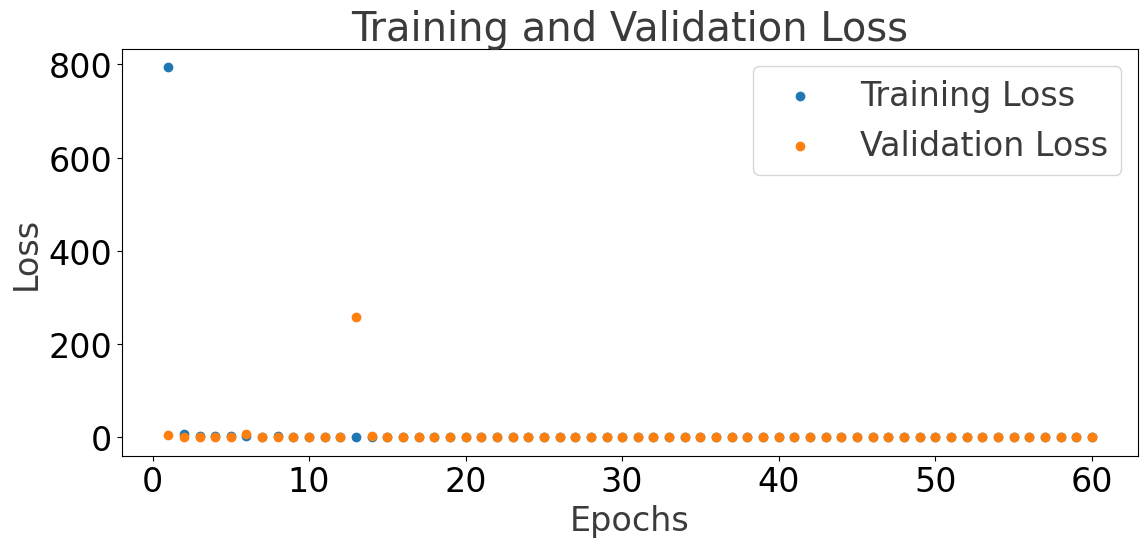

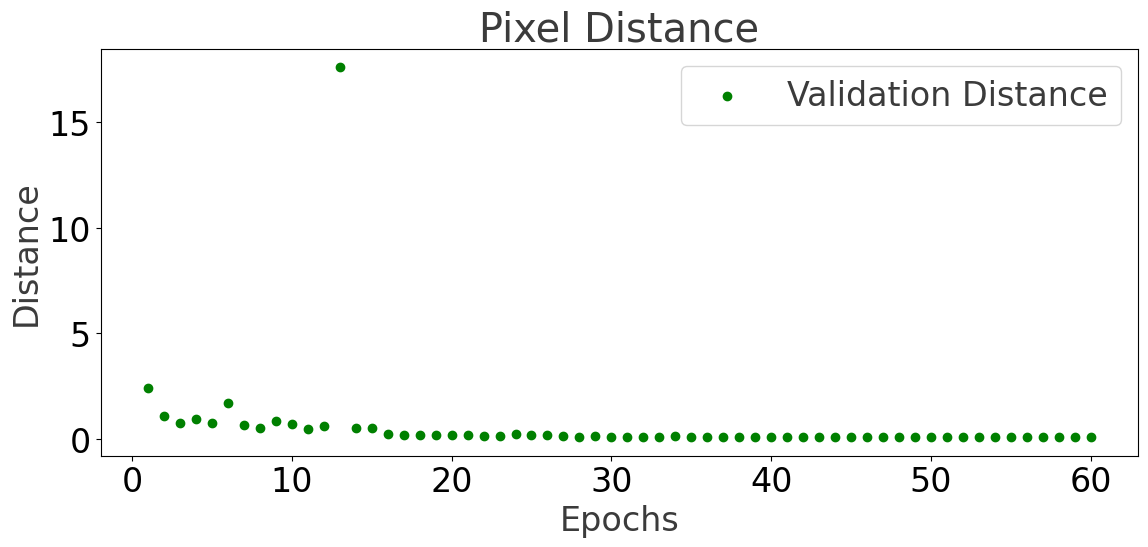

In [172]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("** GPU **")
else:
    device = torch.device("cpu")
    print("** CPU **")

# LTSM_model =RNN1()
LSTM_model= CNNLSTM()
model,train_losses ,val_losses ,val_distances,val_metrics =train(test_loader,train_loader,LSTM_model,device)

In [177]:
# torch.save(model, 'model_LSTM_COB_ast3.pth')
# print("Model paths is saved")

Model paths is saved


In [ ]:
len(train_losses)

45

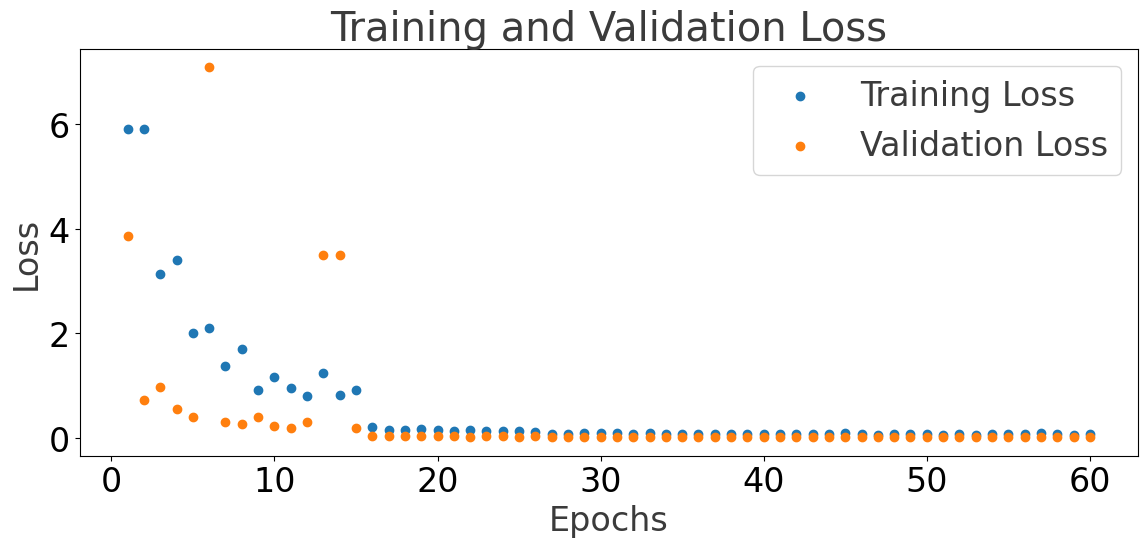

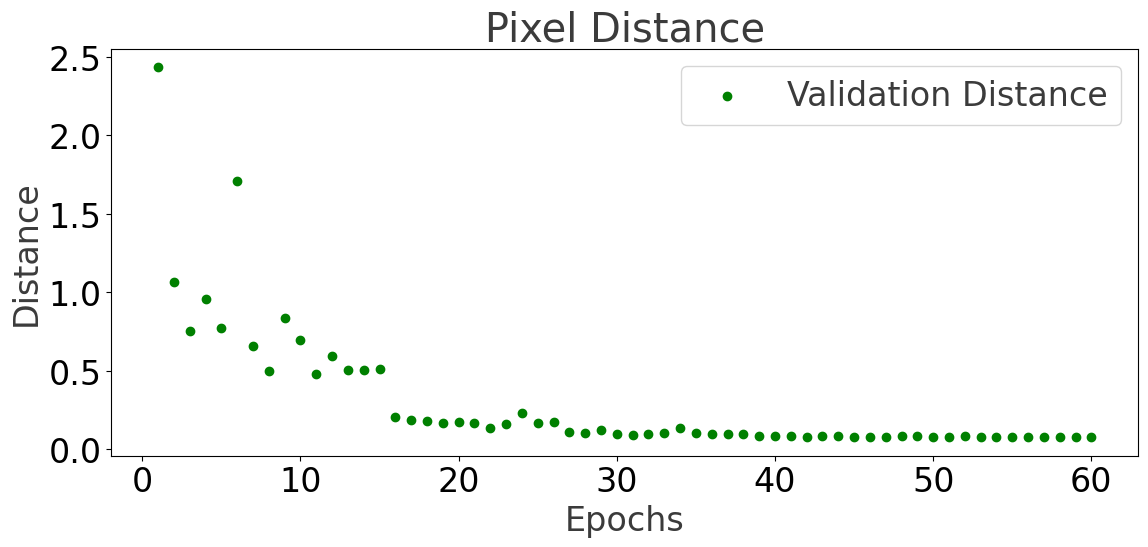

In [176]:
plot_results(60, train_losses, val_losses, val_distances)


In [ ]:
# type(val_metrics)
plot_metrics(45,val_metrics)


AttributeError: 'dict' object has no attribute 'cpu'

##### epoch 1 : #####


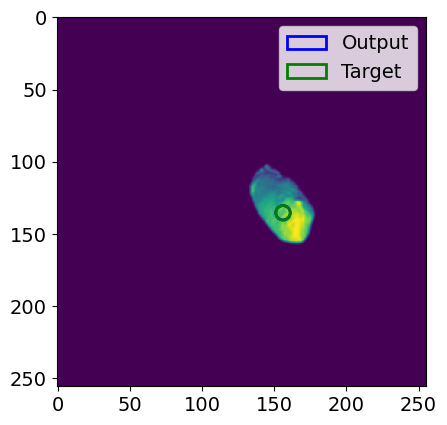

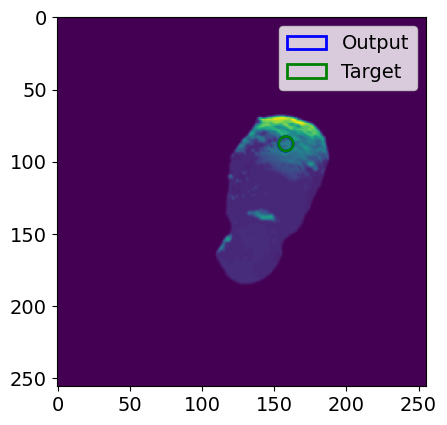

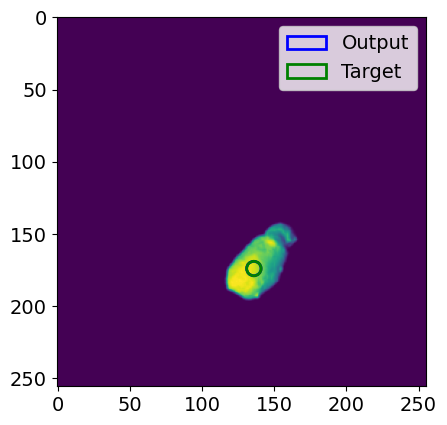

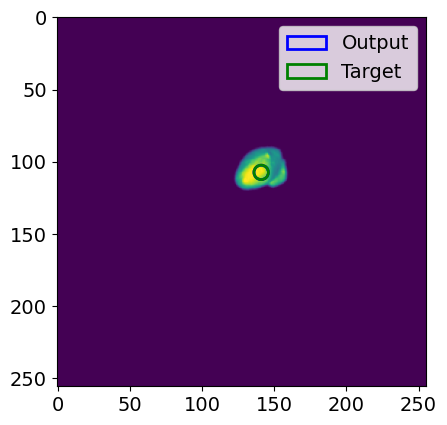

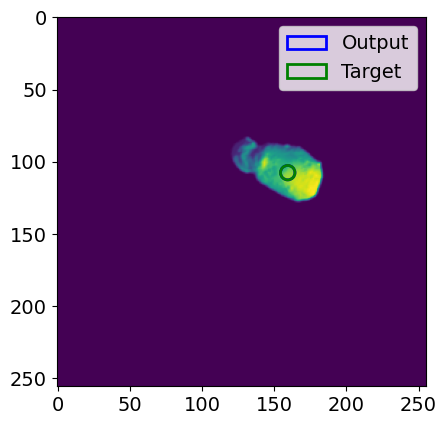

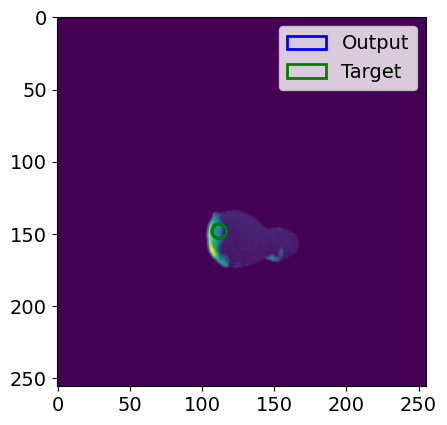

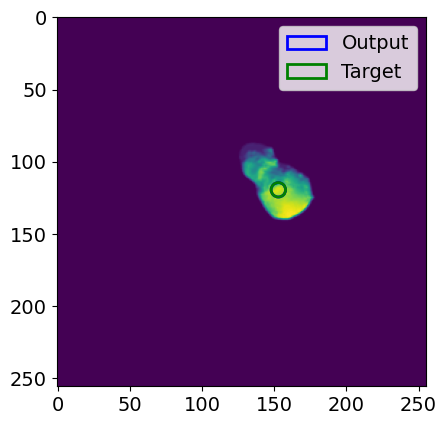

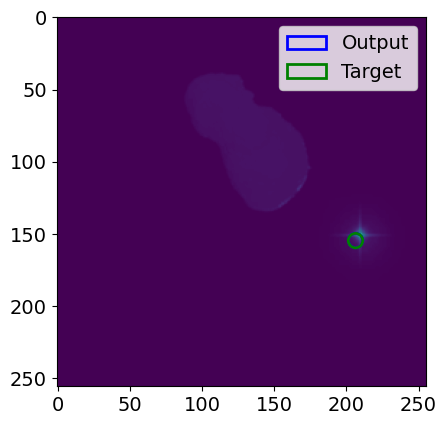

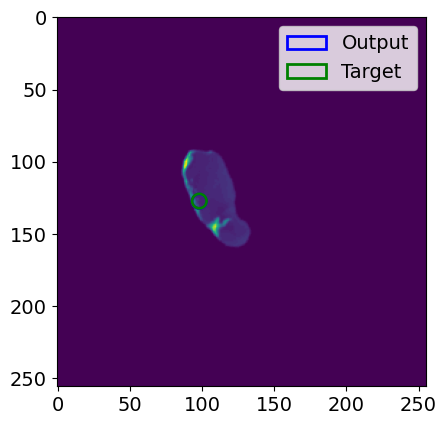

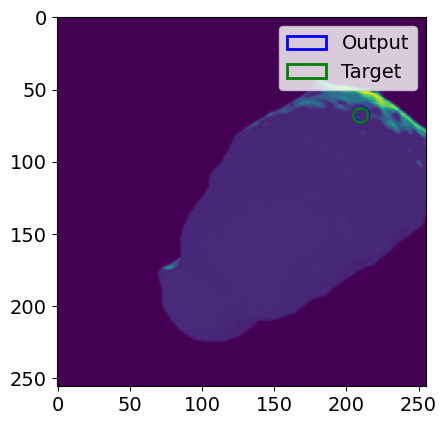

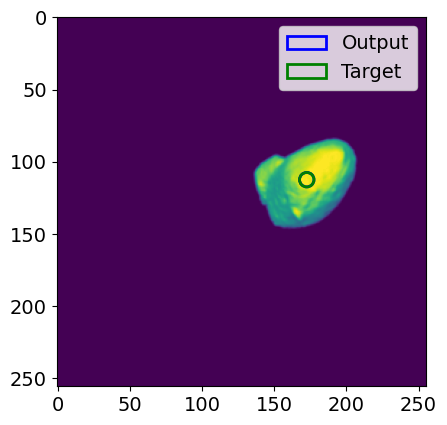

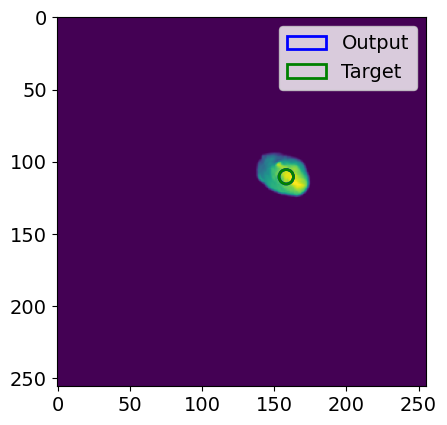

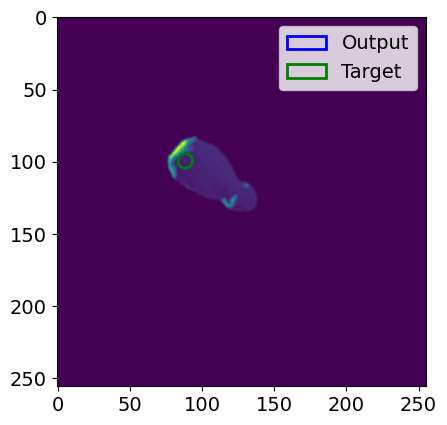

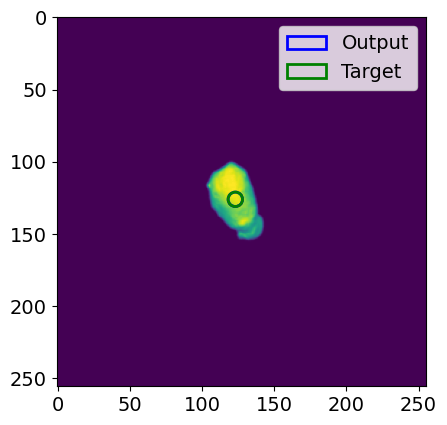

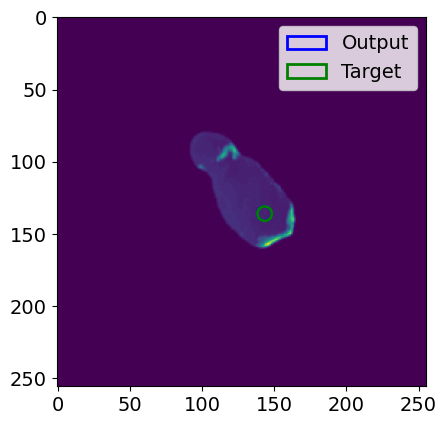

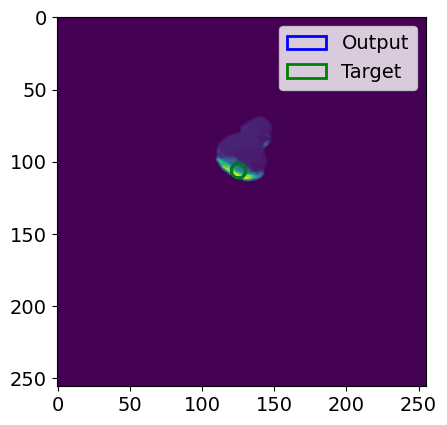

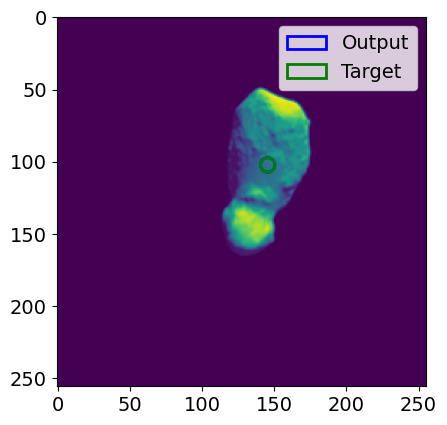

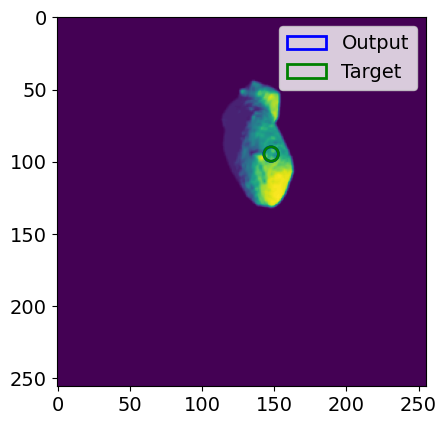

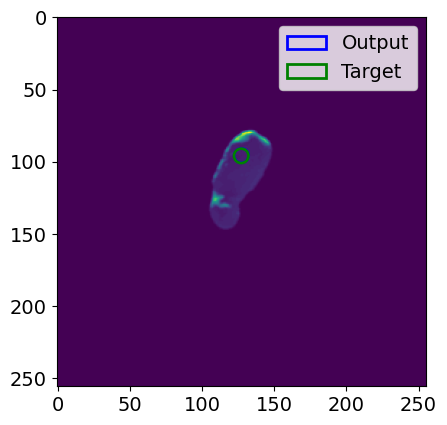

Test Loss: 0.0089, Test Distance: 0.0756, Error: 0.0416
##Metrics##:
MAE : 0.047909148037433624
MSE : 0.009241757914423943
RMSE : 0.2876766622066498
R-squared : 0.9999901652336121
Count: 40144
##### epoch 2 : #####


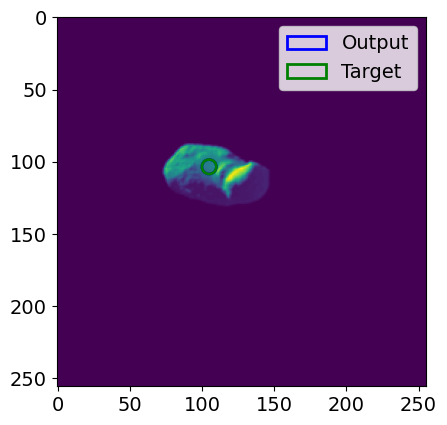

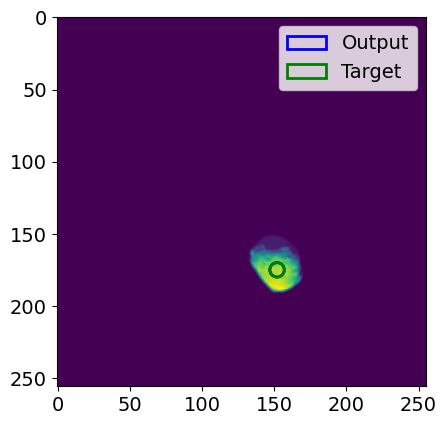

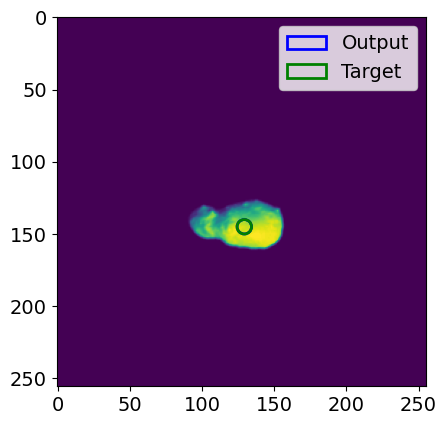

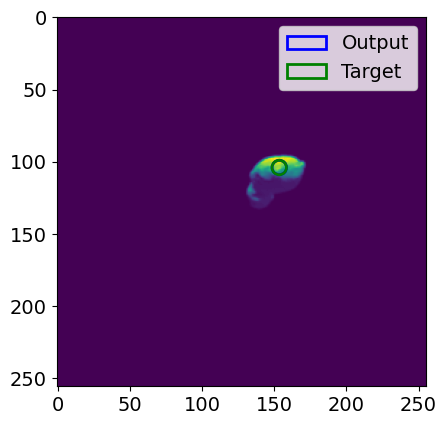

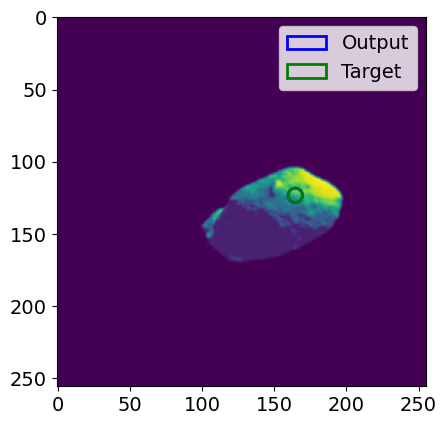

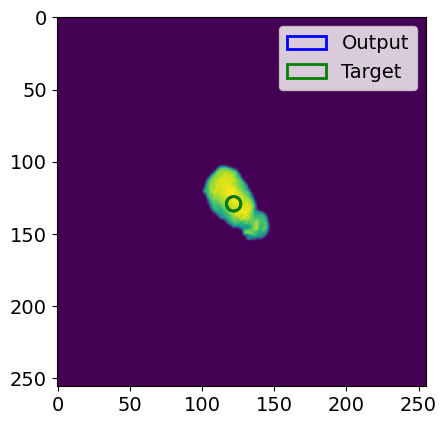

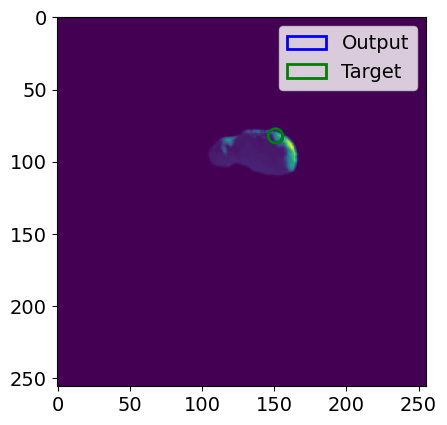

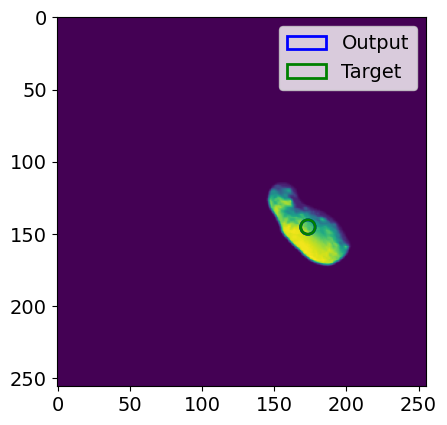

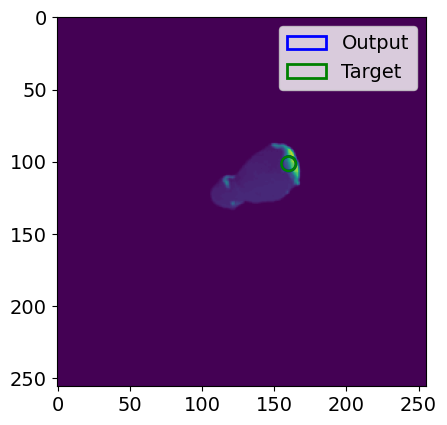

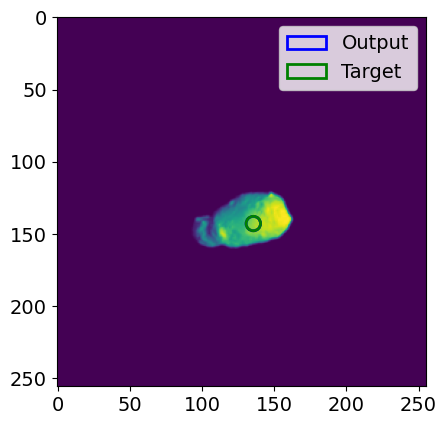

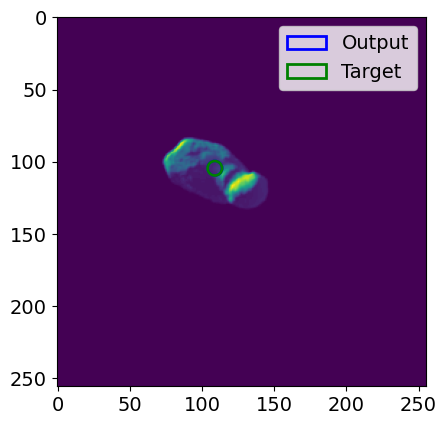

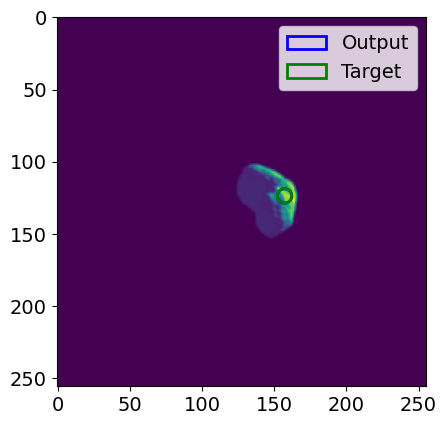

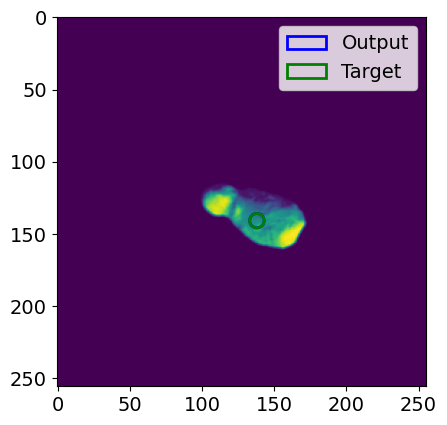

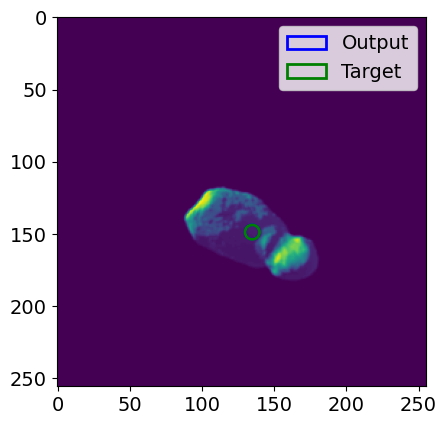

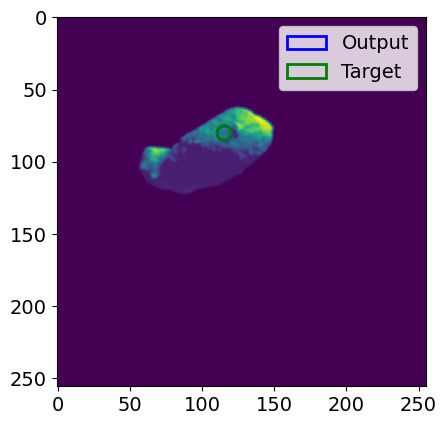

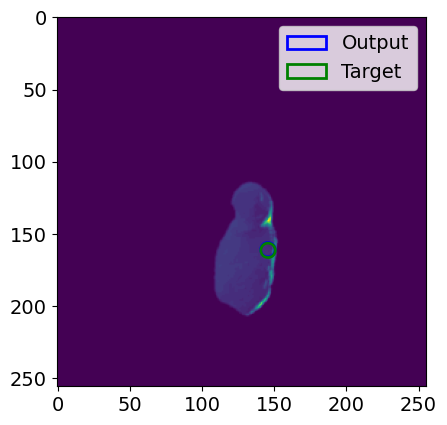

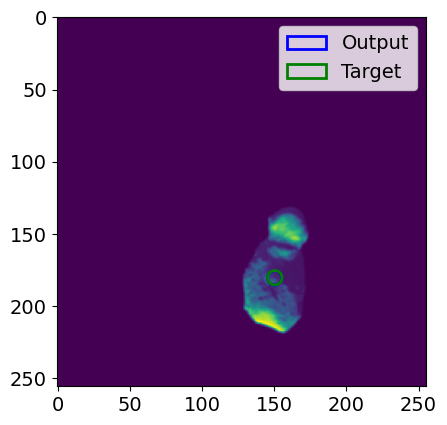

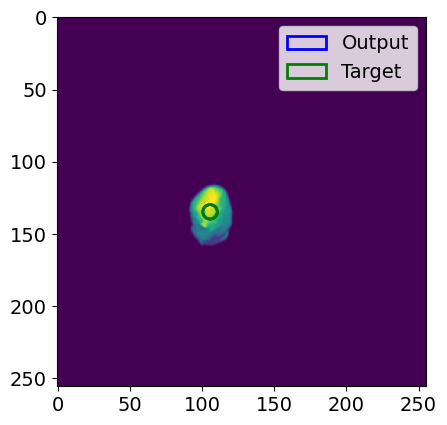

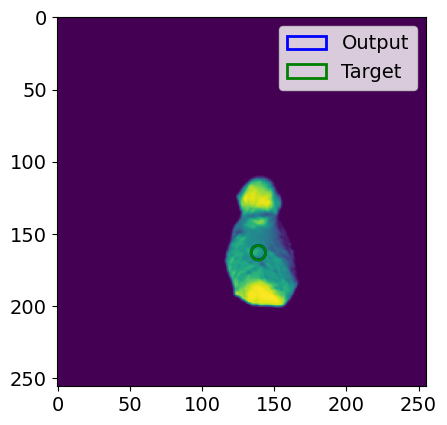

Test Loss: 0.0089, Test Distance: 0.0757, Error: 0.0417
##Metrics##:
MAE : 0.04790915176272392
MSE : 0.009241764433681965
RMSE : 0.28708794713020325
R-squared : 0.9999898672103882
Count: 40144
##### epoch 3 : #####


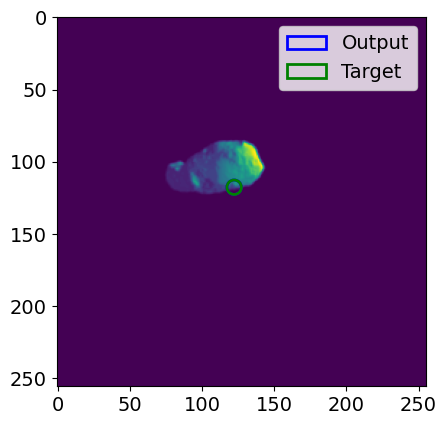

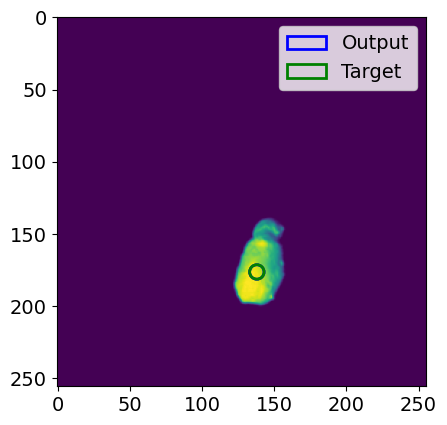

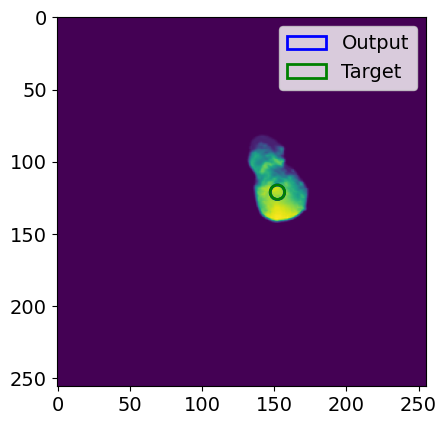

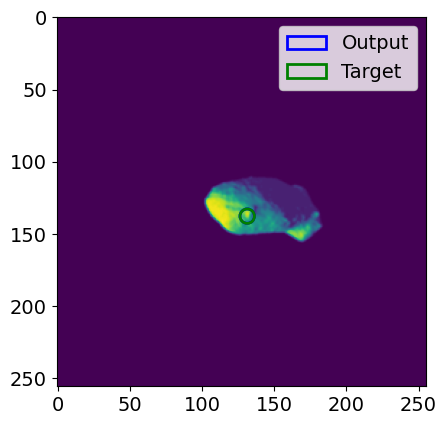

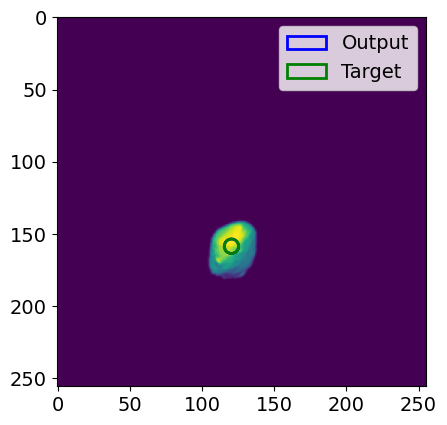

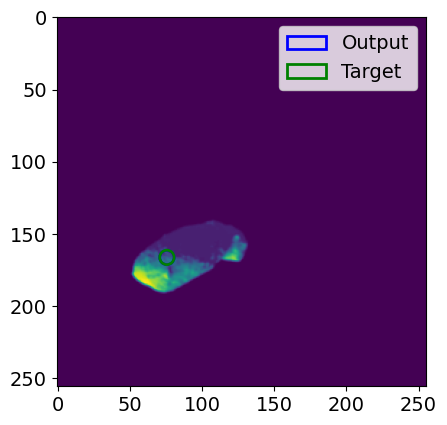

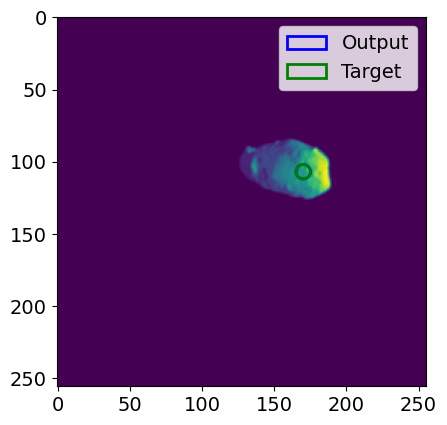

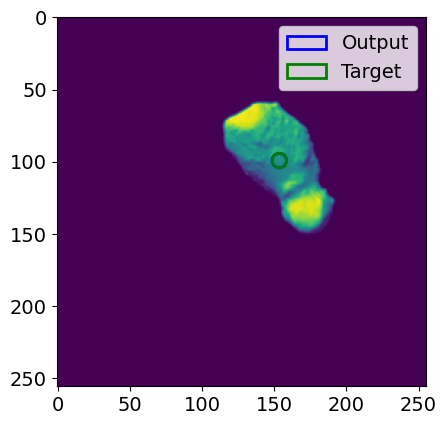

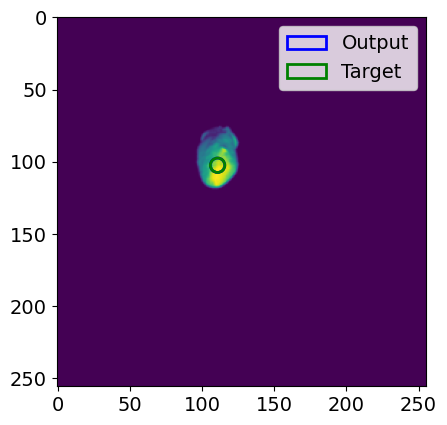

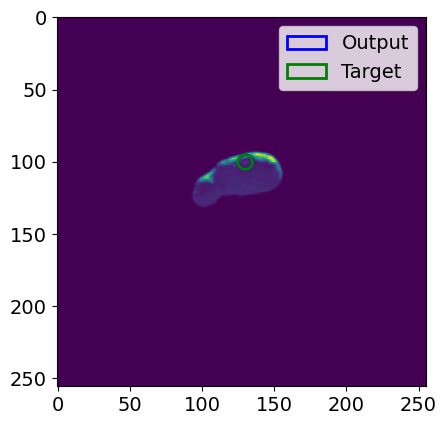

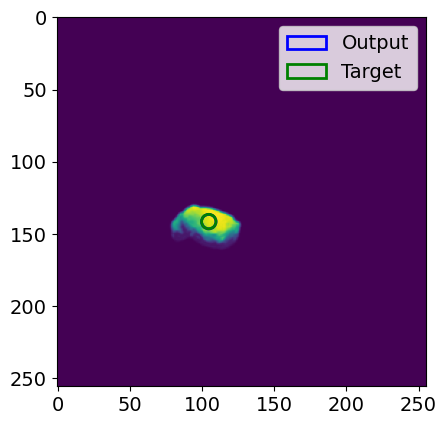

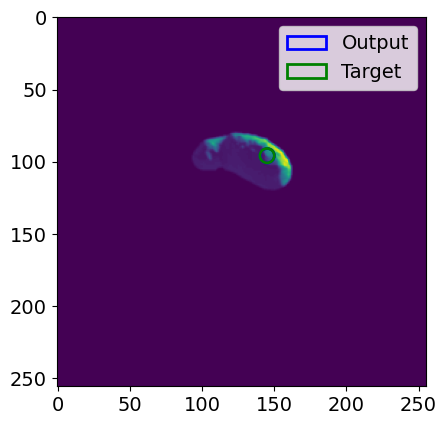

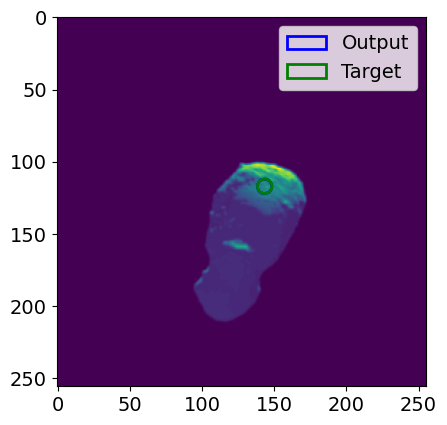

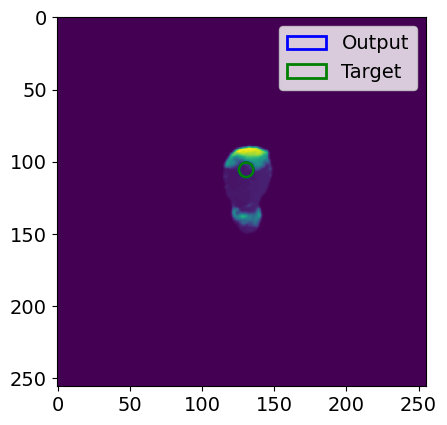

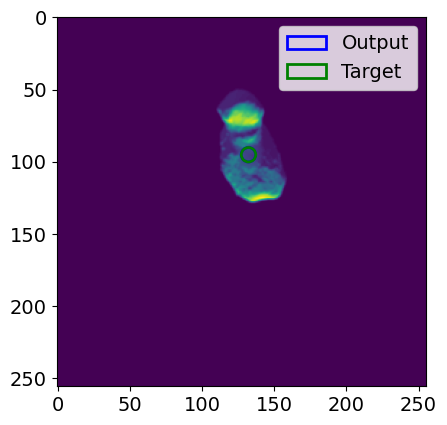

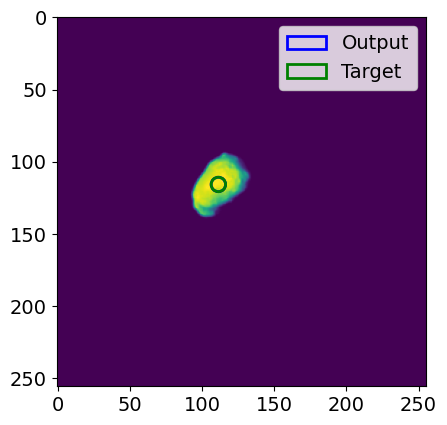

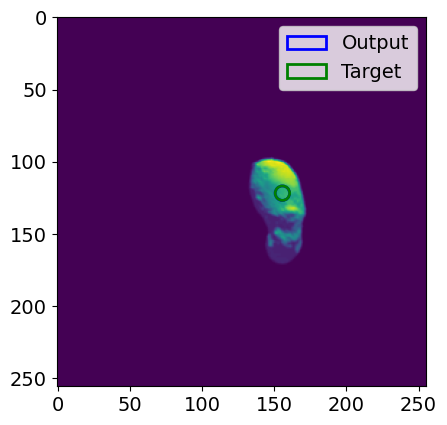

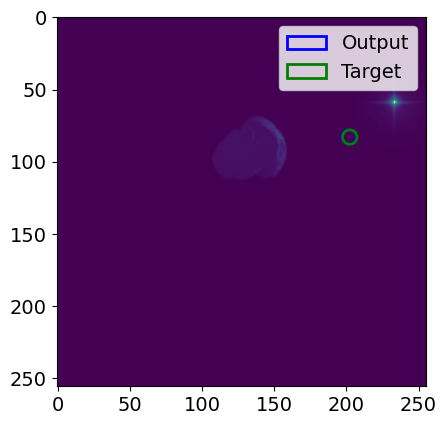

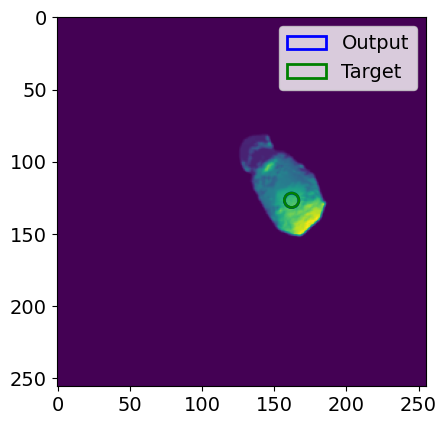

Test Loss: 0.0089, Test Distance: 0.0756, Error: 0.0417
##Metrics##:
MAE : 0.04790916293859482
MSE : 0.009241764433681965
RMSE : 0.2874933183193207
R-squared : 0.9999899864196777
Count: 40144
##### epoch 4 : #####


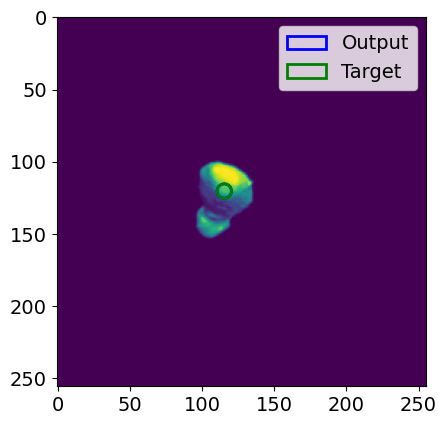

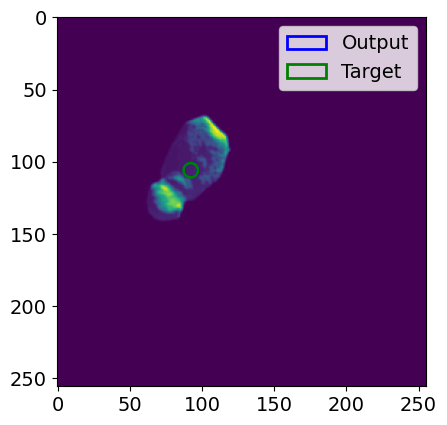

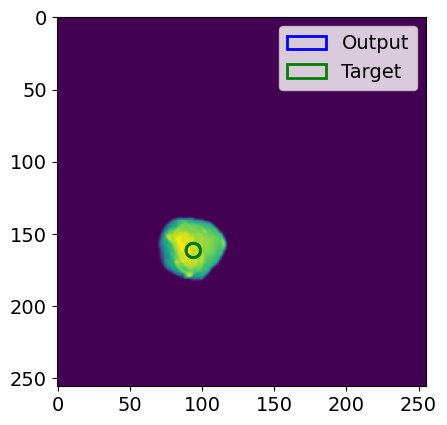

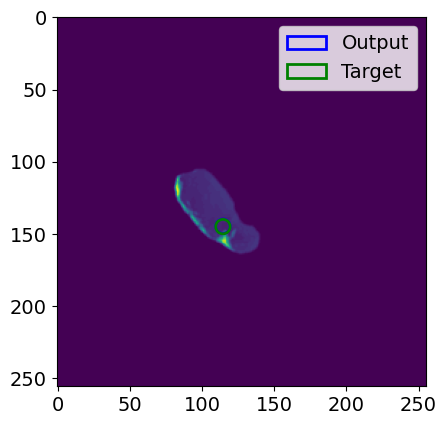

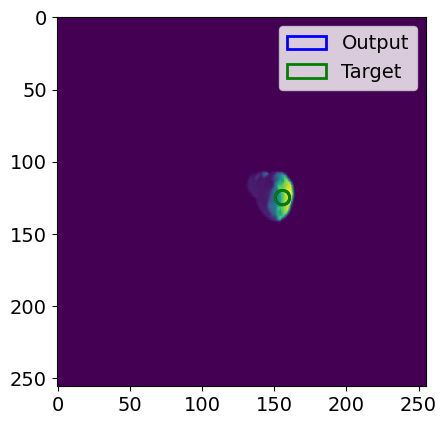

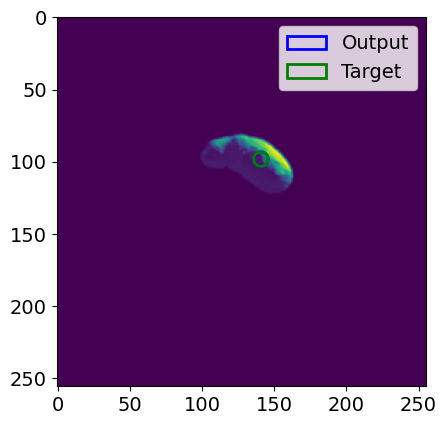

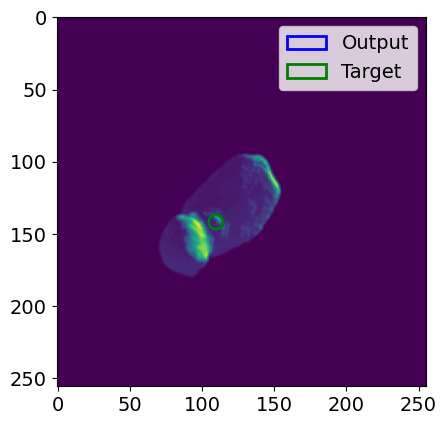

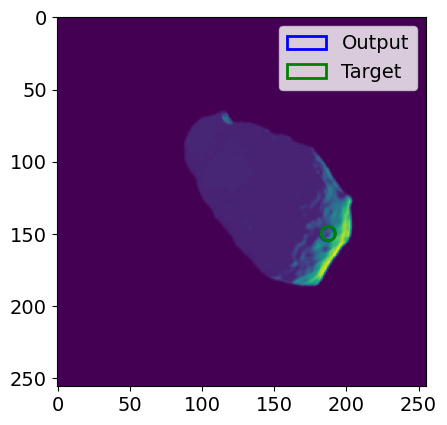

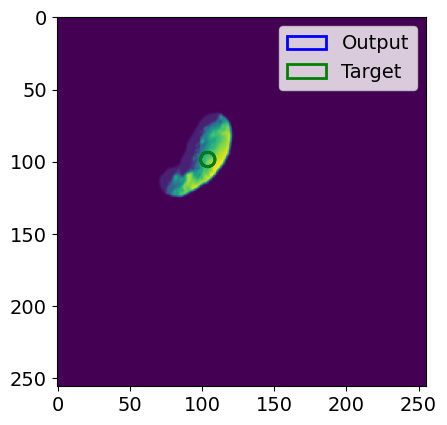

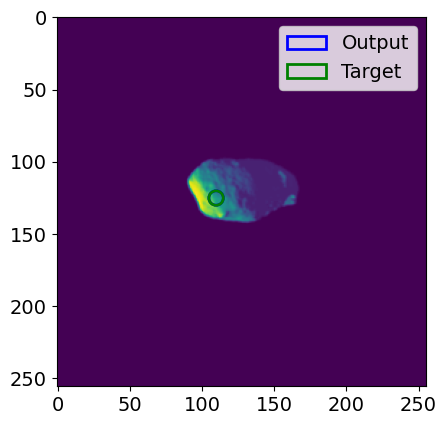

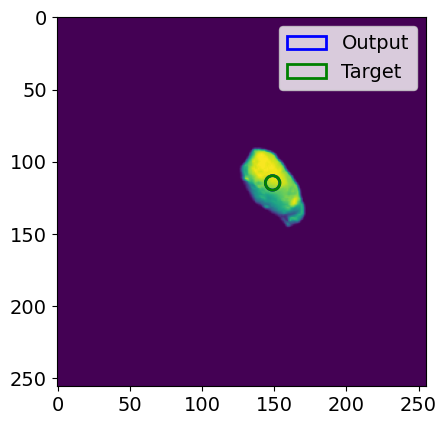

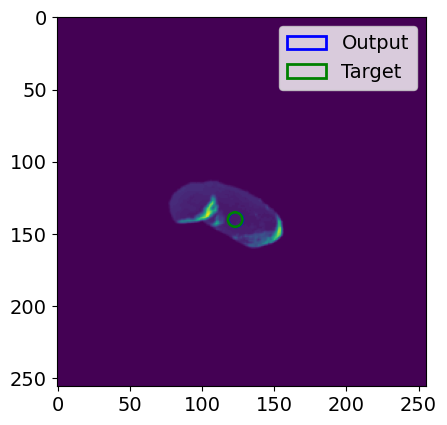

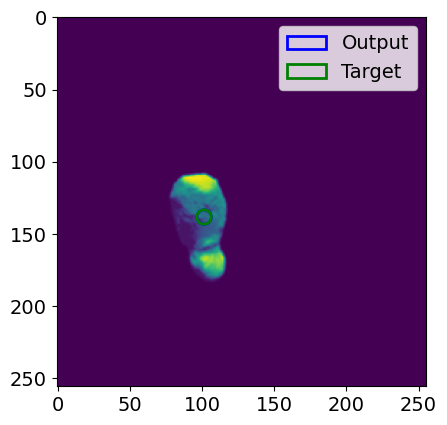

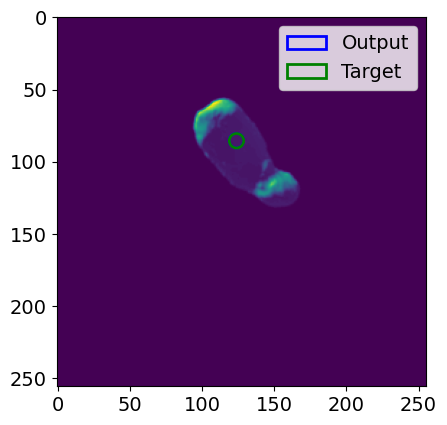

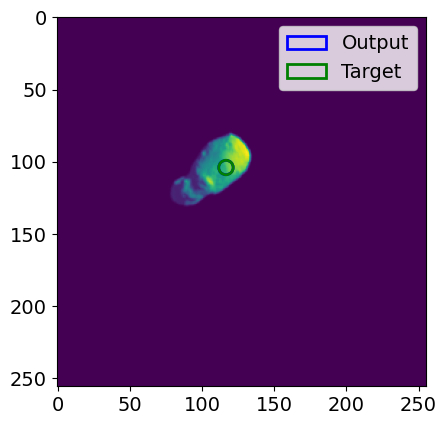

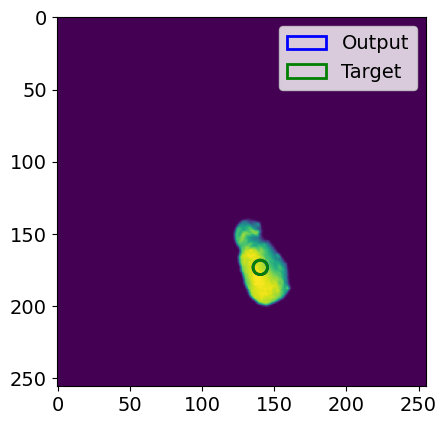

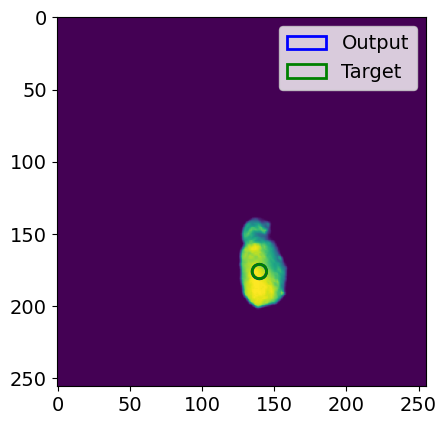

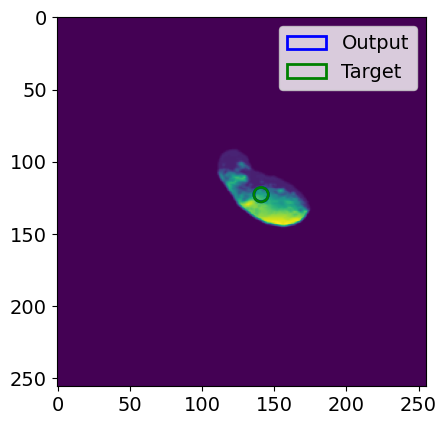

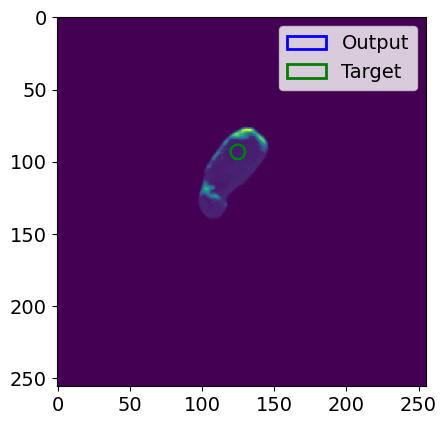

Test Loss: 0.0089, Test Distance: 0.0756, Error: 0.0417
##Metrics##:
MAE : 0.04790918156504631
MSE : 0.00924176350235939
RMSE : 0.2875908315181732
R-squared : 0.9999900460243225
Count: 40144
##### epoch 5 : #####


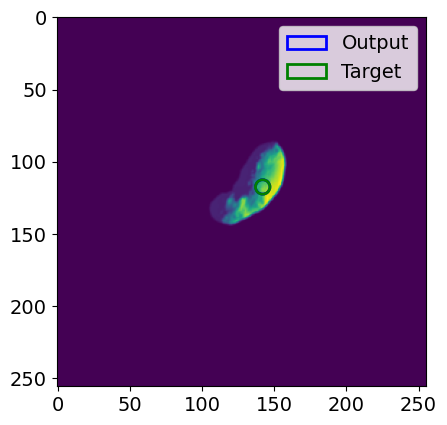

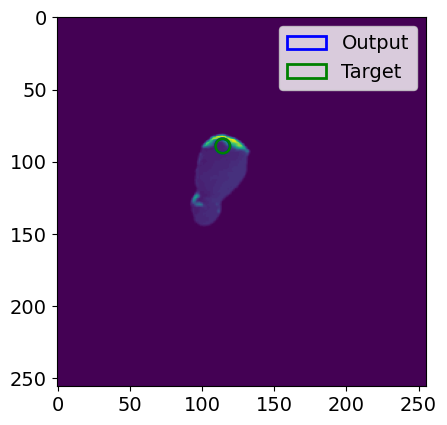

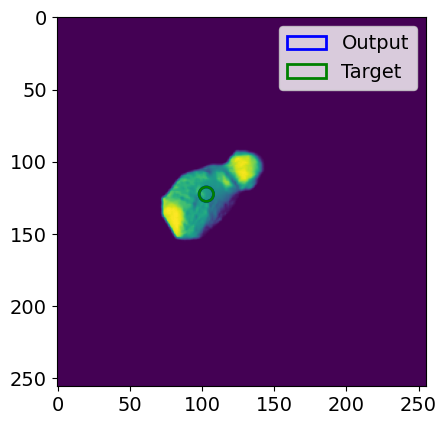

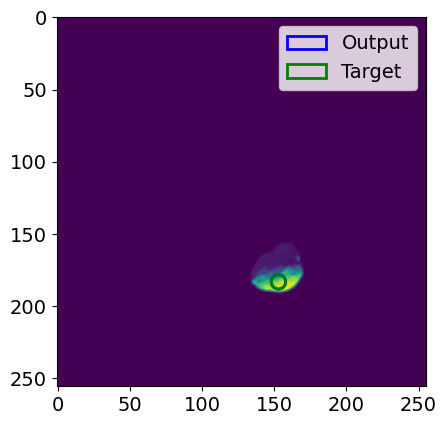

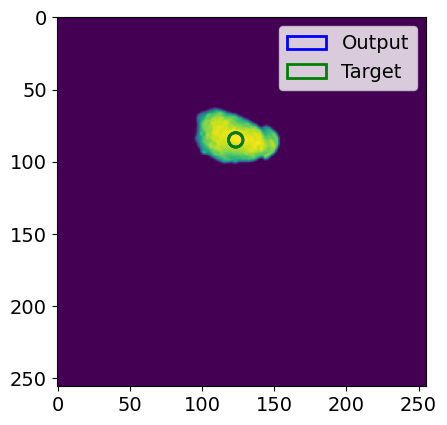

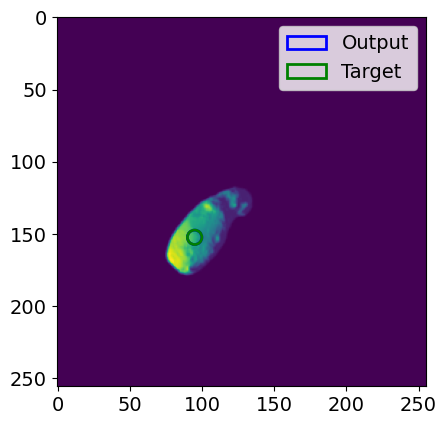

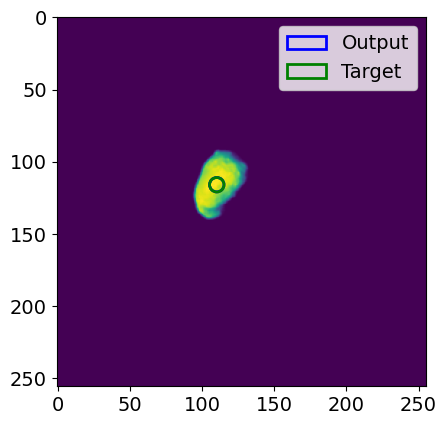

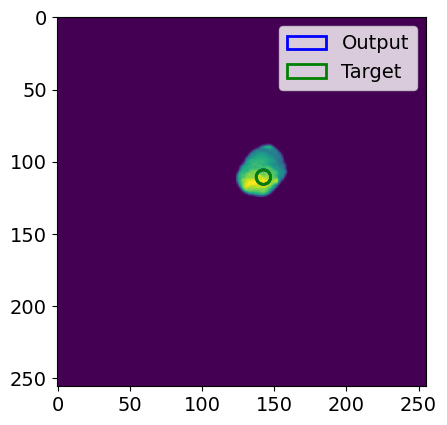

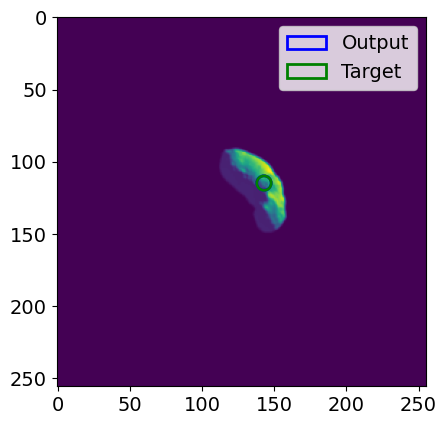

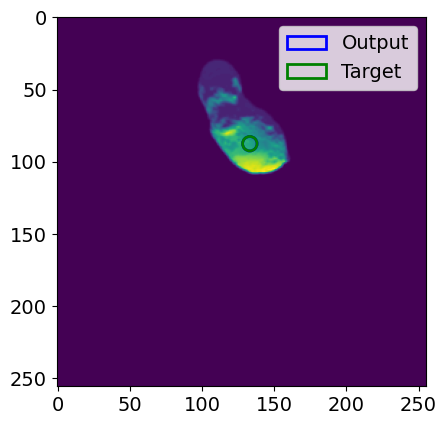

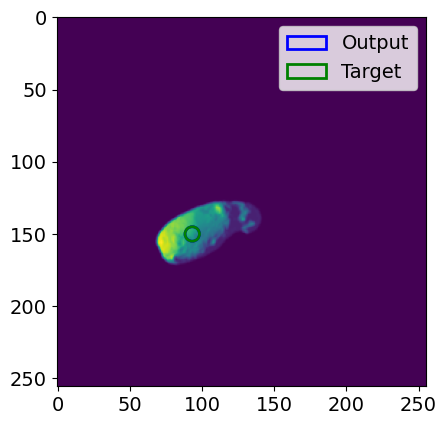

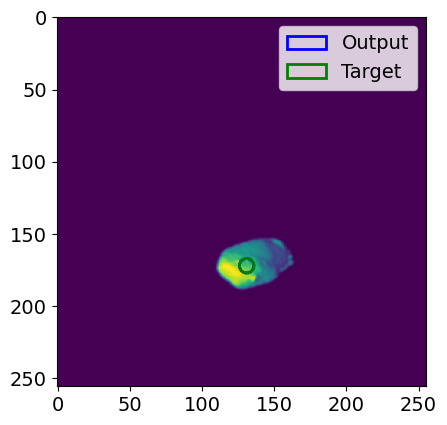

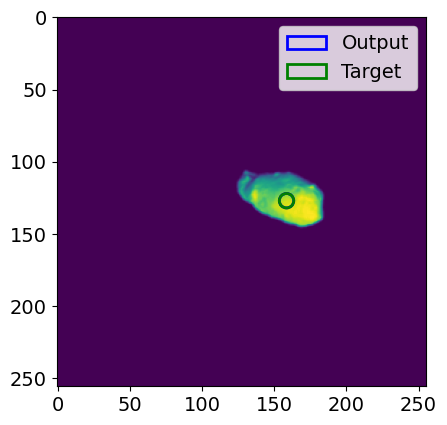

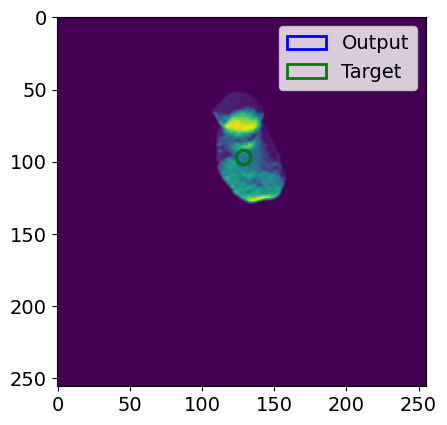

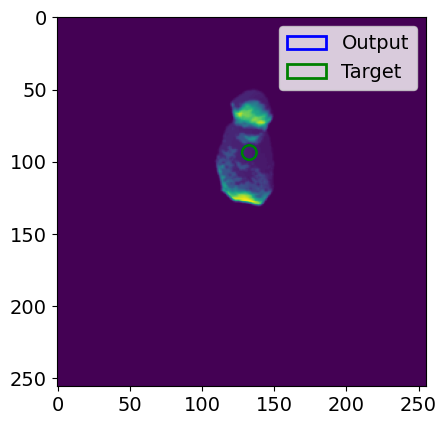

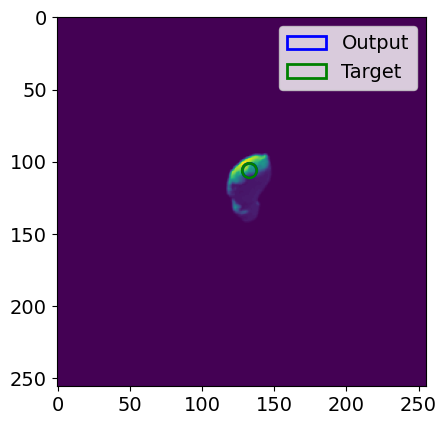

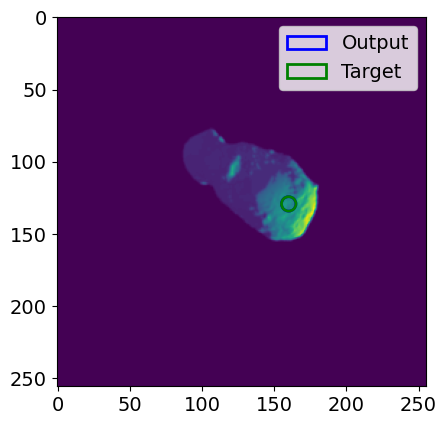

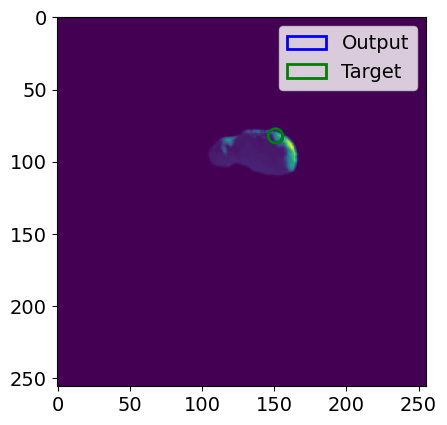

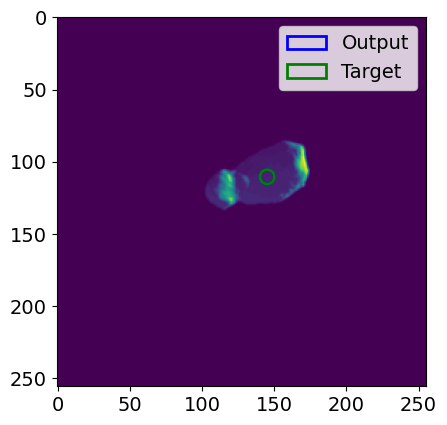

Test Loss: 0.0089, Test Distance: 0.0756, Error: 0.0417
##Metrics##:
MAE : 0.04790915921330452
MSE : 0.009241770952939987
RMSE : 0.2865864634513855
R-squared : 0.9999902844429016
Count: 40144


([0.008907250156610804,
  0.008924238351000287,
  0.008908443760227817,
  0.00890763108998533,
  0.00891008498266988],
 [tensor(0.0756),
  tensor(0.0757),
  tensor(0.0756),
  tensor(0.0756),
  tensor(0.0756)],
 [200.0, 200.0, 200.0, 200.0, 200.0])

In [178]:
# model_test = torch.load('model_RNN_COB.pth')
Test(model, test_loader, device='cpu')

In [ ]:
# testmodel=torch.load('model_CNN1_CoB.pth', map_location=torch.device('cpu'))

##### epoch 1 : #####


c:\Users\bushra.aldhanhani\Documents\UCL\project\UCL_project\generate_dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32)


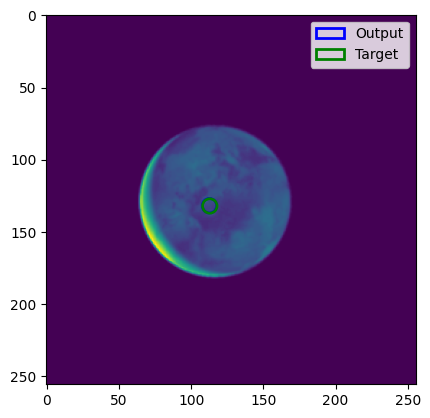

KeyboardInterrupt: 

In [ ]:
# test_losses,test_distances,test_metrics=Test(testmodel, test_loader, device='cpu')